# Introduction

In this notebook, we read the collected benchmarking results (timing and memory usage) and combine them with dataset size. Further, we use the data to assess the scalability of data integration methods.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from matplotlib import rcParams

# Create table with scenario meta data

We have the different scenarios with varying complexity. Here, we add the number of cells per scenario.

For the ATAC data, we test the influence of the number of features in a linear model as they vary considerably from the number of genes in the RNA scenarios.

Mouse brain ATAC small has the following number of features: 110,724 windows, 94,088 peaks, and 3,429 genes, while mouse brain ATAC large has 118,723 windows, 96,924 peaks, and 3,580 genes. In the hvg setting, we selected 2,000 highly variable features, which impacts the runtime and memory usage compared to the full_feature setting. 

In [2]:
scenario = ['human_pancreas', 'tcells_atlas', 
            'immune_cell_hum', 'immune_cell_hum_mou','lung_atlas','simulations_1_1', 'simulations_2'
           ]
scenario_size = [16382, 16803, 
                 33506,97952, 32472,12097, 19318]
scenario_batches = [6,7, 10,23, 16,6,16]
scenario_type = ['RNA', 'RNA','RNA', 'RNA','RNA','RNA','RNA']
scenario_features = [18771,27231,12303,8135,15148,9979,10000]


In [3]:
meta = pd.DataFrame({'scenario1' : scenario, 'size' : scenario_size, 
                     'n_batches' : scenario_batches, 
                     'n_features' : scenario_features,
                     'scenario_type' : scenario_type})

In [4]:
meta

,scenario1,size,n_batches,n_features,scenario_type
0,human_pancreas,16382,6,18771,RNA
1,tcells_atlas,16803,7,27231,RNA
2,immune_cell_hum,33506,10,12303,RNA
3,immune_cell_hum_mou,97952,23,8135,RNA
4,lung_atlas,32472,16,15148,RNA
5,simulations_1_1,12097,6,9979,RNA
6,simulations_2,19318,16,10000,RNA


In [5]:
meta['scenario1'][np.argsort(meta['size'])].values

array(['simulations_1_1', 'human_pancreas', 'tcells_atlas',
       'simulations_2', 'lung_atlas', 'immune_cell_hum',
       'immune_cell_hum_mou'], dtype=object)

In [6]:
meta

,scenario1,size,n_batches,n_features,scenario_type
0,human_pancreas,16382,6,18771,RNA
1,tcells_atlas,16803,7,27231,RNA
2,immune_cell_hum,33506,10,12303,RNA
3,immune_cell_hum_mou,97952,23,8135,RNA
4,lung_atlas,32472,16,15148,RNA
5,simulations_1_1,12097,6,9979,RNA
6,simulations_2,19318,16,10000,RNA


# Load benchmark data

Read all files where a benchmark is available. Daniel Strobl has concatenated all benchmarking results already in a `.csv` file.

In [7]:
data = pd.read_csv('../data/benchmarks.csv')

In [8]:
data

,scenario,s,h_m_s,max_rss,max_vms,max_uss,max_pss,io_in,io_out,mean_load,cpu_time
0,/immune_cell_hum_mou/integration/scaled/hvg/sc...,3516.1988,0:58:36,5387.36,8273.53,5362.53,5370.72,0.0,0.20,98.17,3451.98
1,/immune_cell_hum_mou/integration/scaled/hvg/co...,74.3333,0:01:14,6652.76,7630.73,6634.20,6641.65,0.0,0.18,20.73,15.52
2,/immune_cell_hum_mou/integration/scaled/hvg/sc...,688.0095,0:11:28,10730.89,20002.10,10704.09,10711.02,0.0,0.18,95.61,657.92
3,/immune_cell_hum_mou/integration/scaled/hvg/R/...,270.4579,0:04:30,8444.23,35259.32,8432.86,8434.65,0.0,0.25,91.18,246.86
4,/immune_cell_hum_mou/integration/scaled/hvg/R/...,1967.7935,0:32:47,67768.29,69759.73,67574.32,67578.30,0.0,0.24,96.81,1904.75
...,...,...,...,...,...,...,...,...,...,...,...
95,/tcells_atlas/integration/unscaled/hvg/R/seura...,142.7066,0:02:22,5916.25,35519.71,5905.06,5906.46,0.0,0.24,91.82,131.29
96,/tcells_atlas/integration/unscaled/hvg/R/fastm...,36.7352,0:00:36,1286.46,35658.73,1275.34,1276.95,0.0,0.24,19.31,7.27
97,/tcells_atlas/integration/unscaled/hvg/R/seura...,246.8228,0:04:06,6574.05,35722.73,6562.73,6564.60,0.0,0.24,89.33,221.01
98,/tcells_atlas/integration/unscaled/hvg/R/semiS...,167.5012,0:02:47,7430.27,34784.48,7418.75,7420.38,0.0,0.24,95.36,160.16


Split the scenario names at the `/` and add the info as columns.

In [9]:
#data['scenario'].to_list()

In [10]:
column_names = ['scenario1', 'call', 'scale', 'features','method', 'scenario']
df = pd.DataFrame(columns = column_names)
for file in data['scenario']:
    infos = file.split('/')
    del infos[0]
    tmp = pd.DataFrame({'scenario1': infos[0],
                        'call': infos[1],
                        'scale': infos[2],
                        'features': infos[3],
                        'method': '-'.join(infos[4:]),
                        'scenario': file
                    }, index = ['0'])
    df = pd.concat([df, tmp], ignore_index=True)

In [11]:
df.shape

(100, 6)

In [12]:
[m for m in df['method'].to_list() if m.endswith(".h5ad")]

['scgen.h5ad',
 'combat.h5ad',
 'scanorama.h5ad',
 'scgen.h5ad',
 'scvi.h5ad',
 'scanvi.h5ad',
 'combat.h5ad',
 'scanorama.h5ad',
 'scgen.h5ad',
 'combat.h5ad',
 'scanorama.h5ad',
 'scgen.h5ad',
 'scvi.h5ad',
 'scanvi.h5ad',
 'combat.h5ad',
 'scanorama.h5ad',
 'scgen.h5ad',
 'combat.h5ad',
 'scanorama.h5ad',
 'scgen.h5ad',
 'scvi.h5ad',
 'scanvi.h5ad',
 'combat.h5ad',
 'scanorama.h5ad',
 'scgen.h5ad',
 'combat.h5ad',
 'scanorama.h5ad',
 'scgen.h5ad',
 'scvi.h5ad',
 'scanvi.h5ad',
 'combat.h5ad',
 'scanorama.h5ad',
 'scgen.h5ad',
 'combat.h5ad',
 'scanorama.h5ad',
 'scgen.h5ad',
 'scvi.h5ad',
 'scanvi.h5ad',
 'combat.h5ad',
 'scanorama.h5ad']

In [13]:
[m for m in df['method'].to_list() if m.endswith(".RDS")]

['R-harmony.RDS',
 'R-seuratrpca.RDS',
 'R-fastmnn.RDS',
 'R-seurat.RDS',
 'R-semiSupSTACAS.RDS',
 'R-STACAS.RDS',
 'R-harmony.RDS',
 'R-seuratrpca.RDS',
 'R-fastmnn.RDS',
 'R-seurat.RDS',
 'R-semiSupSTACAS.RDS',
 'R-STACAS.RDS',
 'R-harmony.RDS',
 'R-seuratrpca.RDS',
 'R-fastmnn.RDS',
 'R-seurat.RDS',
 'R-semiSupSTACAS.RDS',
 'R-STACAS.RDS',
 'R-harmony.RDS',
 'R-seuratrpca.RDS',
 'R-fastmnn.RDS',
 'R-seurat.RDS',
 'R-semiSupSTACAS.RDS',
 'R-STACAS.RDS',
 'R-harmony.RDS',
 'R-seuratrpca.RDS',
 'R-fastmnn.RDS',
 'R-seurat.RDS',
 'R-semiSupSTACAS.RDS',
 'R-STACAS.RDS',
 'R-harmony.RDS',
 'R-seuratrpca.RDS',
 'R-fastmnn.RDS',
 'R-seurat.RDS',
 'R-semiSupSTACAS.RDS',
 'R-STACAS.RDS',
 'R-harmony.RDS',
 'R-seuratrpca.RDS',
 'R-fastmnn.RDS',
 'R-seurat.RDS',
 'R-semiSupSTACAS.RDS',
 'R-STACAS.RDS',
 'R-harmony.RDS',
 'R-seuratrpca.RDS',
 'R-fastmnn.RDS',
 'R-seurat.RDS',
 'R-semiSupSTACAS.RDS',
 'R-STACAS.RDS',
 'R-harmony.RDS',
 'R-seuratrpca.RDS',
 'R-fastmnn.RDS',
 'R-seurat.RDS',
 'R-se

In [14]:
np.unique(df['scenario1'])

array(['human_pancreas', 'immune_cell_hum', 'immune_cell_hum_mou',
       'lung_atlas', 'tcells_atlas'], dtype=object)

In [15]:
df

,scenario1,call,scale,features,method,scenario
0,immune_cell_hum_mou,integration,scaled,hvg,scgen.h5ad,/immune_cell_hum_mou/integration/scaled/hvg/sc...
1,immune_cell_hum_mou,integration,scaled,hvg,combat.h5ad,/immune_cell_hum_mou/integration/scaled/hvg/co...
2,immune_cell_hum_mou,integration,scaled,hvg,scanorama.h5ad,/immune_cell_hum_mou/integration/scaled/hvg/sc...
3,immune_cell_hum_mou,integration,scaled,hvg,R-harmony.RDS,/immune_cell_hum_mou/integration/scaled/hvg/R/...
4,immune_cell_hum_mou,integration,scaled,hvg,R-seuratrpca.RDS,/immune_cell_hum_mou/integration/scaled/hvg/R/...
...,...,...,...,...,...,...
95,tcells_atlas,integration,unscaled,hvg,R-seuratrpca.RDS,/tcells_atlas/integration/unscaled/hvg/R/seura...
96,tcells_atlas,integration,unscaled,hvg,R-fastmnn.RDS,/tcells_atlas/integration/unscaled/hvg/R/fastm...
97,tcells_atlas,integration,unscaled,hvg,R-seurat.RDS,/tcells_atlas/integration/unscaled/hvg/R/seura...
98,tcells_atlas,integration,unscaled,hvg,R-semiSupSTACAS.RDS,/tcells_atlas/integration/unscaled/hvg/R/semiS...


# Process benchmark data

In our simulations, we had some methods in R and some in python. Therefore, we exclude `seurat.h5ad`, `harmony.h5ad` and `conos.h5ad`, because those files show only the timing for file conversion.

Further, we exclude the `prep_h5ad` and `prep_RDS` steps.

In [16]:
df['method'].value_counts()

scgen.h5ad             10
combat.h5ad            10
scanorama.h5ad         10
R-harmony.RDS          10
R-seuratrpca.RDS       10
R-fastmnn.RDS          10
R-seurat.RDS           10
R-semiSupSTACAS.RDS    10
R-STACAS.RDS           10
scvi.h5ad               5
scanvi.h5ad             5
Name: method, dtype: int64

In [17]:
idx = np.invert(np.in1d(df['method'], ['seurat.h5ad', 'harmony.h5ad', 'conos.h5ad', 'prep_h5ad', 'prep_RDS']))

In [18]:
integ_runs = df.iloc[idx, :]

In [19]:
idx2 = np.invert(np.in1d(integ_runs['scenario'], ['simulations_1']))

In [20]:
integ_runs = integ_runs.iloc[idx2, :]

In [21]:
integ_runs['scenario1'].value_counts()

immune_cell_hum_mou    20
immune_cell_hum        20
human_pancreas         20
lung_atlas             20
tcells_atlas           20
Name: scenario1, dtype: int64

In [22]:
methods = [meth.split('.')[0] for meth in integ_runs['method']]
methods2 = [meth.split('-')[-1] for meth in methods]

In [23]:
integ_runs['method'] = methods2

In [24]:
integ_runs['method'].value_counts()

scgen            10
combat           10
scanorama        10
harmony          10
seuratrpca       10
fastmnn          10
seurat           10
semiSupSTACAS    10
STACAS           10
scvi              5
scanvi            5
Name: method, dtype: int64

In [25]:
integ_runs

,scenario1,call,scale,features,method,scenario
0,immune_cell_hum_mou,integration,scaled,hvg,scgen,/immune_cell_hum_mou/integration/scaled/hvg/sc...
1,immune_cell_hum_mou,integration,scaled,hvg,combat,/immune_cell_hum_mou/integration/scaled/hvg/co...
2,immune_cell_hum_mou,integration,scaled,hvg,scanorama,/immune_cell_hum_mou/integration/scaled/hvg/sc...
3,immune_cell_hum_mou,integration,scaled,hvg,harmony,/immune_cell_hum_mou/integration/scaled/hvg/R/...
4,immune_cell_hum_mou,integration,scaled,hvg,seuratrpca,/immune_cell_hum_mou/integration/scaled/hvg/R/...
...,...,...,...,...,...,...
95,tcells_atlas,integration,unscaled,hvg,seuratrpca,/tcells_atlas/integration/unscaled/hvg/R/seura...
96,tcells_atlas,integration,unscaled,hvg,fastmnn,/tcells_atlas/integration/unscaled/hvg/R/fastm...
97,tcells_atlas,integration,unscaled,hvg,seurat,/tcells_atlas/integration/unscaled/hvg/R/seura...
98,tcells_atlas,integration,unscaled,hvg,semiSupSTACAS,/tcells_atlas/integration/unscaled/hvg/R/semiS...


Sanity check whether we collected the correct files.

In [26]:
pd.crosstab(integ_runs['scenario1'],integ_runs['method'], margins=True)

method,STACAS,combat,fastmnn,harmony,scanorama,scanvi,scgen,scvi,semiSupSTACAS,seurat,seuratrpca,All
scenario1,,,,,,,,,,,,
human_pancreas,2,2,2,2,2,1,2,1,2,2,2,20
immune_cell_hum,2,2,2,2,2,1,2,1,2,2,2,20
immune_cell_hum_mou,2,2,2,2,2,1,2,1,2,2,2,20
lung_atlas,2,2,2,2,2,1,2,1,2,2,2,20
tcells_atlas,2,2,2,2,2,1,2,1,2,2,2,20
All,10,10,10,10,10,5,10,5,10,10,10,100


## Merge metadata and benchmark results

Merge data set sizes and batch number to table with integration runs.

In [27]:
runs_meta = integ_runs.merge(meta, on='scenario1')

In [28]:
runs_meta.head()

,scenario1,call,scale,features,method,scenario,size,n_batches,n_features,scenario_type
0,immune_cell_hum_mou,integration,scaled,hvg,scgen,/immune_cell_hum_mou/integration/scaled/hvg/sc...,97952,23,8135,RNA
1,immune_cell_hum_mou,integration,scaled,hvg,combat,/immune_cell_hum_mou/integration/scaled/hvg/co...,97952,23,8135,RNA
2,immune_cell_hum_mou,integration,scaled,hvg,scanorama,/immune_cell_hum_mou/integration/scaled/hvg/sc...,97952,23,8135,RNA
3,immune_cell_hum_mou,integration,scaled,hvg,harmony,/immune_cell_hum_mou/integration/scaled/hvg/R/...,97952,23,8135,RNA
4,immune_cell_hum_mou,integration,scaled,hvg,seuratrpca,/immune_cell_hum_mou/integration/scaled/hvg/R/...,97952,23,8135,RNA


In [29]:
runs_meta.to_csv("./benchmark_meta.csv")

Replace the number of features for 'hvg' by 2000.

In [30]:
runs_meta.loc[runs_meta['features']=='hvg', 'n_features'] = 2000

In [31]:
runs_meta['n_features'].value_counts()

2000    100
Name: n_features, dtype: int64

In [32]:
runs_meta['method'].value_counts()

scgen            10
combat           10
scanorama        10
harmony          10
seuratrpca       10
fastmnn          10
seurat           10
semiSupSTACAS    10
STACAS           10
scvi              5
scanvi            5
Name: method, dtype: int64

Merge with the benchmark data.

In [33]:
runs_meta = runs_meta.merge(data, on='scenario')

Save to file.

In [34]:
runs_meta.to_csv('./combined_benchmark_performance_measures.csv')

Look up individual methods.

In [35]:
runs_meta.loc[runs_meta['method']=='fastmnn'][['scenario1', 'features', 'scale', 'max_pss']]

,scenario1,features,scale,max_pss
5,immune_cell_hum_mou,hvg,scaled,7933.22
16,immune_cell_hum_mou,hvg,unscaled,5984.55
25,immune_cell_hum,hvg,scaled,4644.63
36,immune_cell_hum,hvg,unscaled,2767.84
45,human_pancreas,hvg,scaled,3087.70
56,human_pancreas,hvg,unscaled,3021.71
65,lung_atlas,hvg,scaled,5197.48
76,lung_atlas,hvg,unscaled,2812.24
85,tcells_atlas,hvg,scaled,3222.20
96,tcells_atlas,hvg,unscaled,1276.95


In [36]:
runs_meta.loc[runs_meta['method']=='seuratrpca'][['scenario1', 'features', 'scale', 'max_pss']]

,scenario1,features,scale,max_pss
4,immune_cell_hum_mou,hvg,scaled,67578.30
15,immune_cell_hum_mou,hvg,unscaled,39352.87
24,immune_cell_hum,hvg,scaled,31319.53
35,immune_cell_hum,hvg,unscaled,12523.44
44,human_pancreas,hvg,scaled,19575.36
55,human_pancreas,hvg,unscaled,16684.46
64,lung_atlas,hvg,scaled,35898.20
75,lung_atlas,hvg,unscaled,20728.85
84,tcells_atlas,hvg,scaled,22147.58
95,tcells_atlas,hvg,unscaled,5906.46


In [37]:
runs_meta.loc[runs_meta['method']=='seurat'][['scenario1', 'features', 'scale', 'max_pss']]

,scenario1,features,scale,max_pss
6,immune_cell_hum_mou,hvg,scaled,95368.89
17,immune_cell_hum_mou,hvg,unscaled,45526.17
26,immune_cell_hum,hvg,scaled,38107.26
37,immune_cell_hum,hvg,unscaled,14421.33
46,human_pancreas,hvg,scaled,20877.94
57,human_pancreas,hvg,unscaled,23471.27
66,lung_atlas,hvg,scaled,52212.36
77,lung_atlas,hvg,unscaled,22314.83
86,tcells_atlas,hvg,scaled,26523.35
97,tcells_atlas,hvg,unscaled,6564.60


In [38]:
runs_meta.loc[runs_meta['method']=='harmony'][['scenario1', 'features', 'scale', 'max_pss']]

,scenario1,features,scale,max_pss
3,immune_cell_hum_mou,hvg,scaled,8434.65
14,immune_cell_hum_mou,hvg,unscaled,3522.98
23,immune_cell_hum,hvg,scaled,2119.39
34,immune_cell_hum,hvg,unscaled,2557.44
43,human_pancreas,hvg,scaled,2537.88
54,human_pancreas,hvg,unscaled,3056.59
63,lung_atlas,hvg,scaled,4148.16
74,lung_atlas,hvg,unscaled,2179.60
83,tcells_atlas,hvg,scaled,1972.12
94,tcells_atlas,hvg,unscaled,1325.45


# Visualisation

Here, we visualise the CPU time ("s") and the memory usage ("max_uss" and "max_pss") for all runs.

In [39]:
runs_meta

,scenario1,call,scale,features,method,scenario,size,n_batches,n_features,scenario_type,s,h_m_s,max_rss,max_vms,max_uss,max_pss,io_in,io_out,mean_load,cpu_time
0,immune_cell_hum_mou,integration,scaled,hvg,scgen,/immune_cell_hum_mou/integration/scaled/hvg/sc...,97952,23,2000,RNA,3516.1988,0:58:36,5387.36,8273.53,5362.53,5370.72,0.0,0.20,98.17,3451.98
1,immune_cell_hum_mou,integration,scaled,hvg,combat,/immune_cell_hum_mou/integration/scaled/hvg/co...,97952,23,2000,RNA,74.3333,0:01:14,6652.76,7630.73,6634.20,6641.65,0.0,0.18,20.73,15.52
2,immune_cell_hum_mou,integration,scaled,hvg,scanorama,/immune_cell_hum_mou/integration/scaled/hvg/sc...,97952,23,2000,RNA,688.0095,0:11:28,10730.89,20002.10,10704.09,10711.02,0.0,0.18,95.61,657.92
3,immune_cell_hum_mou,integration,scaled,hvg,harmony,/immune_cell_hum_mou/integration/scaled/hvg/R/...,97952,23,2000,RNA,270.4579,0:04:30,8444.23,35259.32,8432.86,8434.65,0.0,0.25,91.18,246.86
4,immune_cell_hum_mou,integration,scaled,hvg,seuratrpca,/immune_cell_hum_mou/integration/scaled/hvg/R/...,97952,23,2000,RNA,1967.7935,0:32:47,67768.29,69759.73,67574.32,67578.30,0.0,0.24,96.81,1904.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,tcells_atlas,integration,unscaled,hvg,seuratrpca,/tcells_atlas/integration/unscaled/hvg/R/seura...,16803,7,2000,RNA,142.7066,0:02:22,5916.25,35519.71,5905.06,5906.46,0.0,0.24,91.82,131.29
96,tcells_atlas,integration,unscaled,hvg,fastmnn,/tcells_atlas/integration/unscaled/hvg/R/fastm...,16803,7,2000,RNA,36.7352,0:00:36,1286.46,35658.73,1275.34,1276.95,0.0,0.24,19.31,7.27
97,tcells_atlas,integration,unscaled,hvg,seurat,/tcells_atlas/integration/unscaled/hvg/R/seura...,16803,7,2000,RNA,246.8228,0:04:06,6574.05,35722.73,6562.73,6564.60,0.0,0.24,89.33,221.01
98,tcells_atlas,integration,unscaled,hvg,semiSupSTACAS,/tcells_atlas/integration/unscaled/hvg/R/semiS...,16803,7,2000,RNA,167.5012,0:02:47,7430.27,34784.48,7418.75,7420.38,0.0,0.24,95.36,160.16


Due to the fair amount of data, we tried two different color schemes: `tab20c` and the `Polychrome36` from R version `4.0` (hex color codes were copied manually).

In [40]:
hue_order = runs_meta["method"].unique()
hue_order

array(['scgen', 'combat', 'scanorama', 'harmony', 'seuratrpca', 'fastmnn',
       'seurat', 'semiSupSTACAS', 'STACAS', 'scvi', 'scanvi'],
      dtype=object)

In [41]:
#use colors from the Polychrome36 palette
colors = ['#5A5156', '#E4E1E3', '#F6222E', '#FE00FA', '#16FF32', 
          '#3283FE', '#FEAF16', '#B00068', '#1CFFCE', '#90AD1C', '#2ED9FF',
          '#DEA0FD', '#AA0DFE', '#F8A19F', '#325A9B', '#C4451C' 
         ]
sb.set_palette(sb.color_palette(colors))

## Boxplots

Visualise runtime and memory use per method and data scenario in a boxplot.

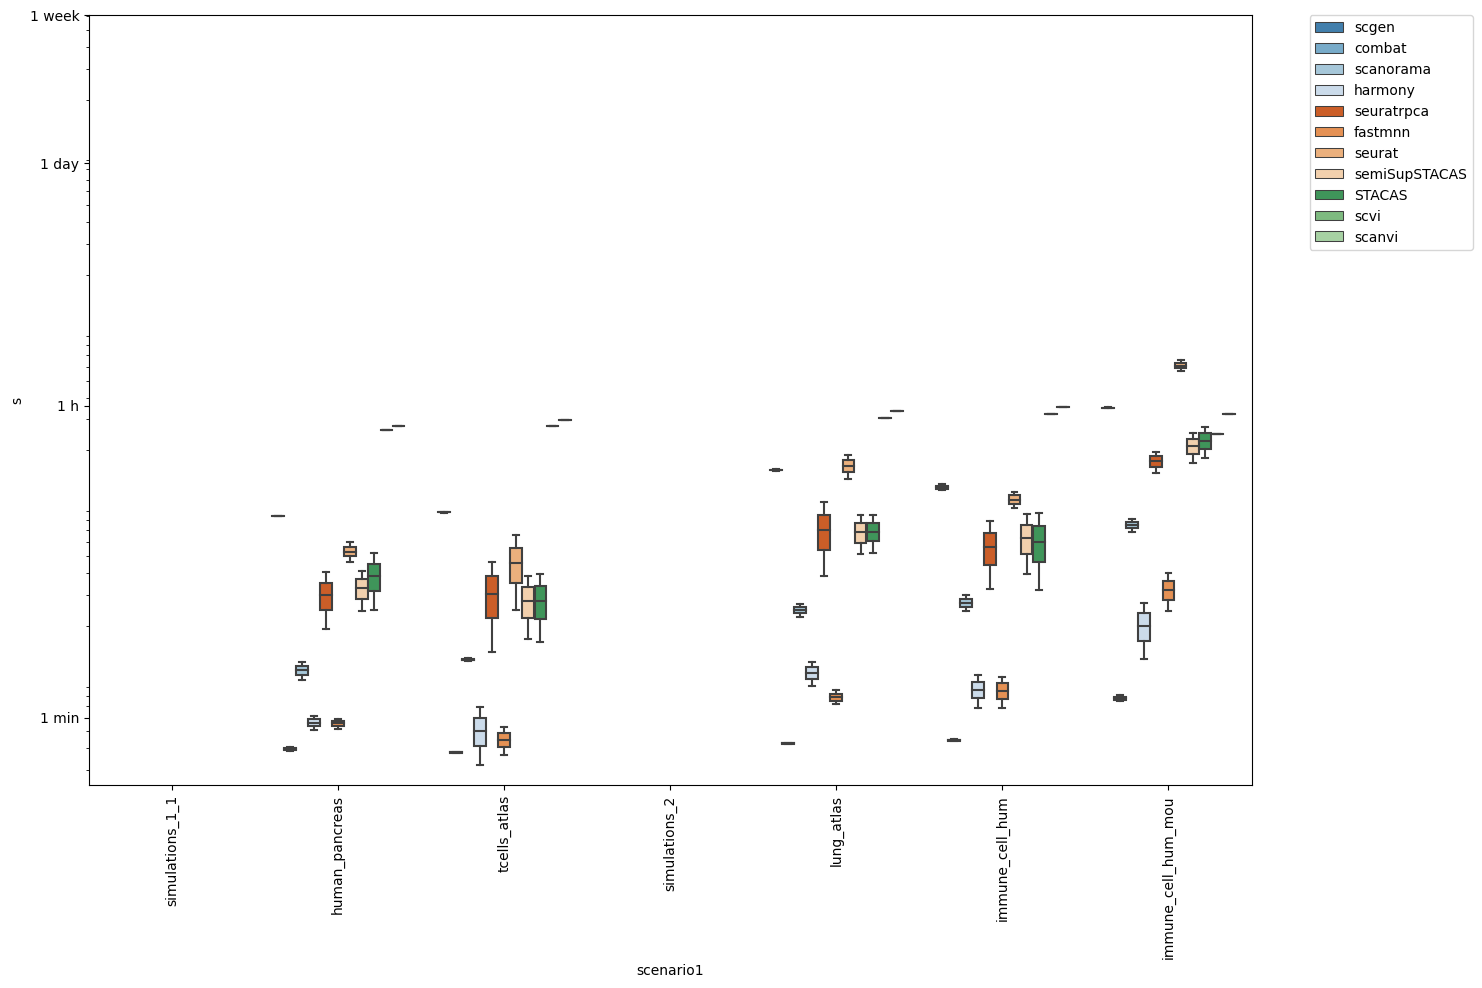

In [42]:
rcParams['figure.figsize']=(15,10)
ax = sb.boxplot(x="scenario1", y="s", hue='method', 
                hue_order= hue_order,
                order = meta['scenario1'][np.argsort(meta['size'])].values,
                data=runs_meta, palette='tab20c')
ax.set(yscale="log")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.yticks([60, 3600, 86400,604800], ['1 min', '1 h', '1 day', '1 week'])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

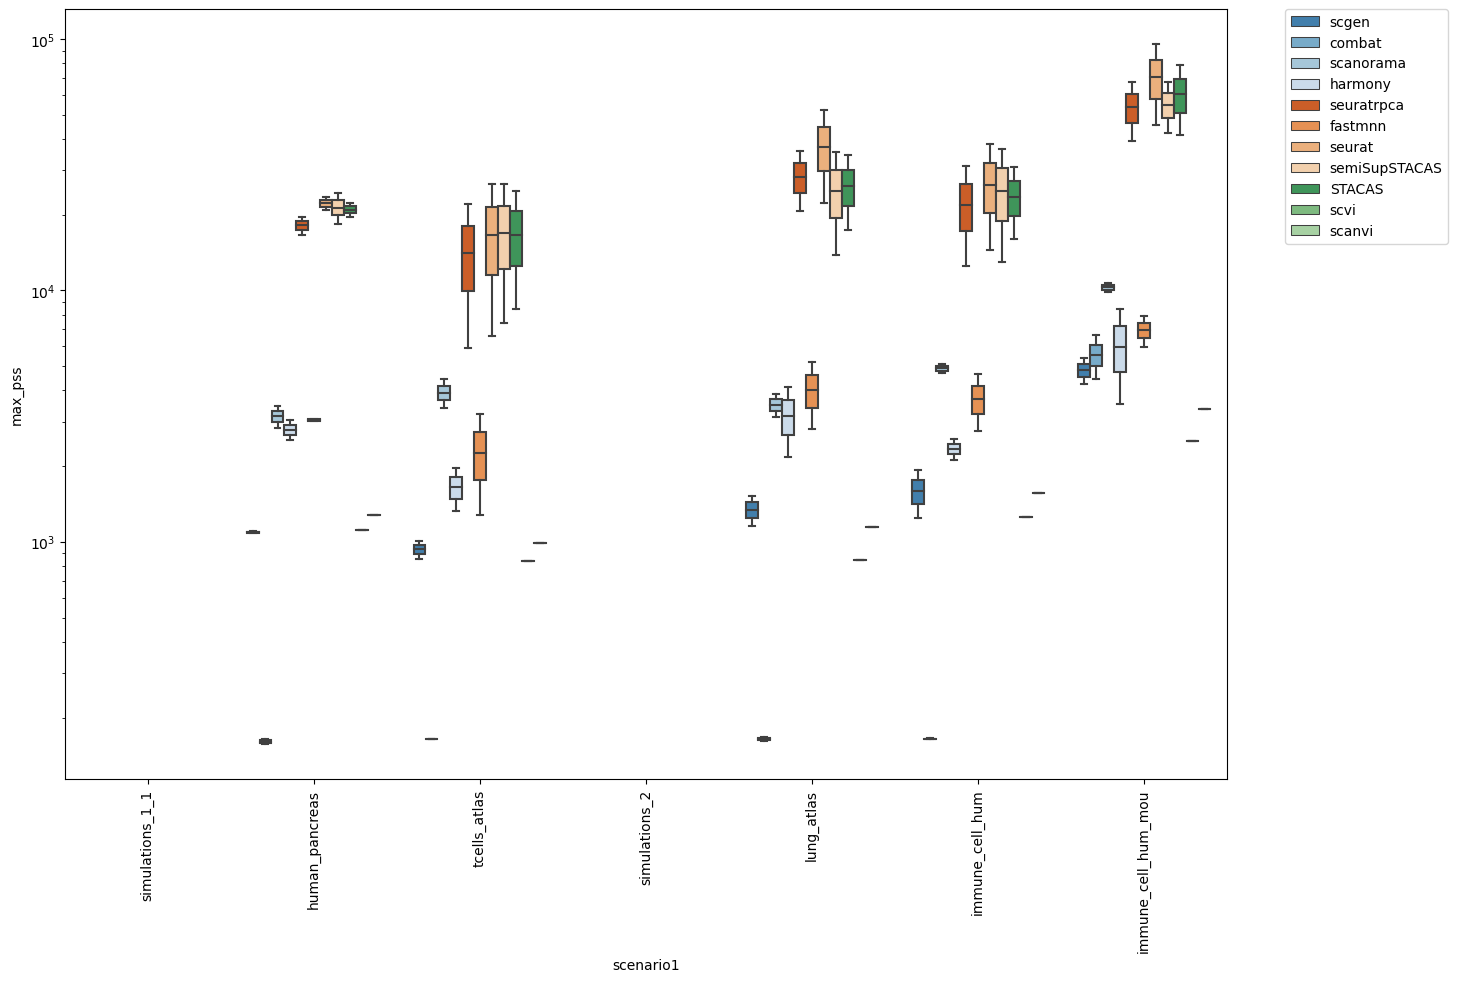

In [43]:
rcParams['figure.figsize']=(15,10)
ax = sb.boxplot(x="scenario1", y="max_pss", hue='method', 
                hue_order=hue_order,
                order = meta['scenario1'][np.argsort(meta['size'])].values,
                data=runs_meta, palette='tab20c')
ax.set(yscale="log")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

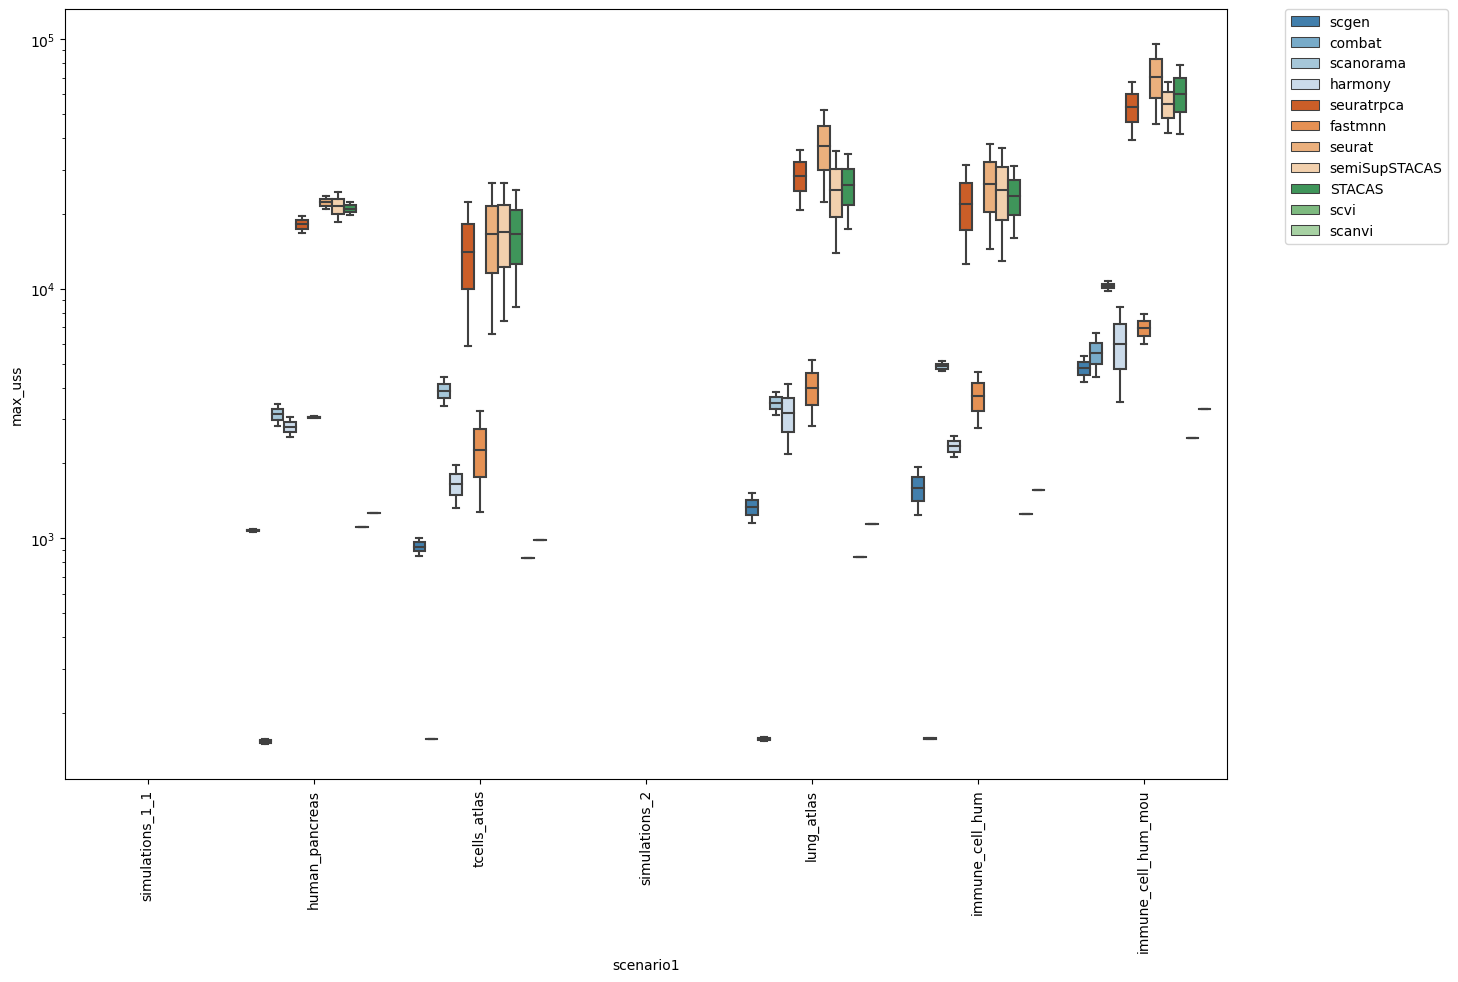

In [44]:
rcParams['figure.figsize']=(15,10)
ax = sb.boxplot(x="scenario1", y="max_uss", hue='method', 
                hue_order=hue_order,
                order = meta['scenario1'][np.argsort(meta['size'])].values,
                data=runs_meta, palette='tab20c')
ax.set(yscale="log")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

## Boxplots per batch

Visualise runtime and memory use per method and data scenario in a boxplot.

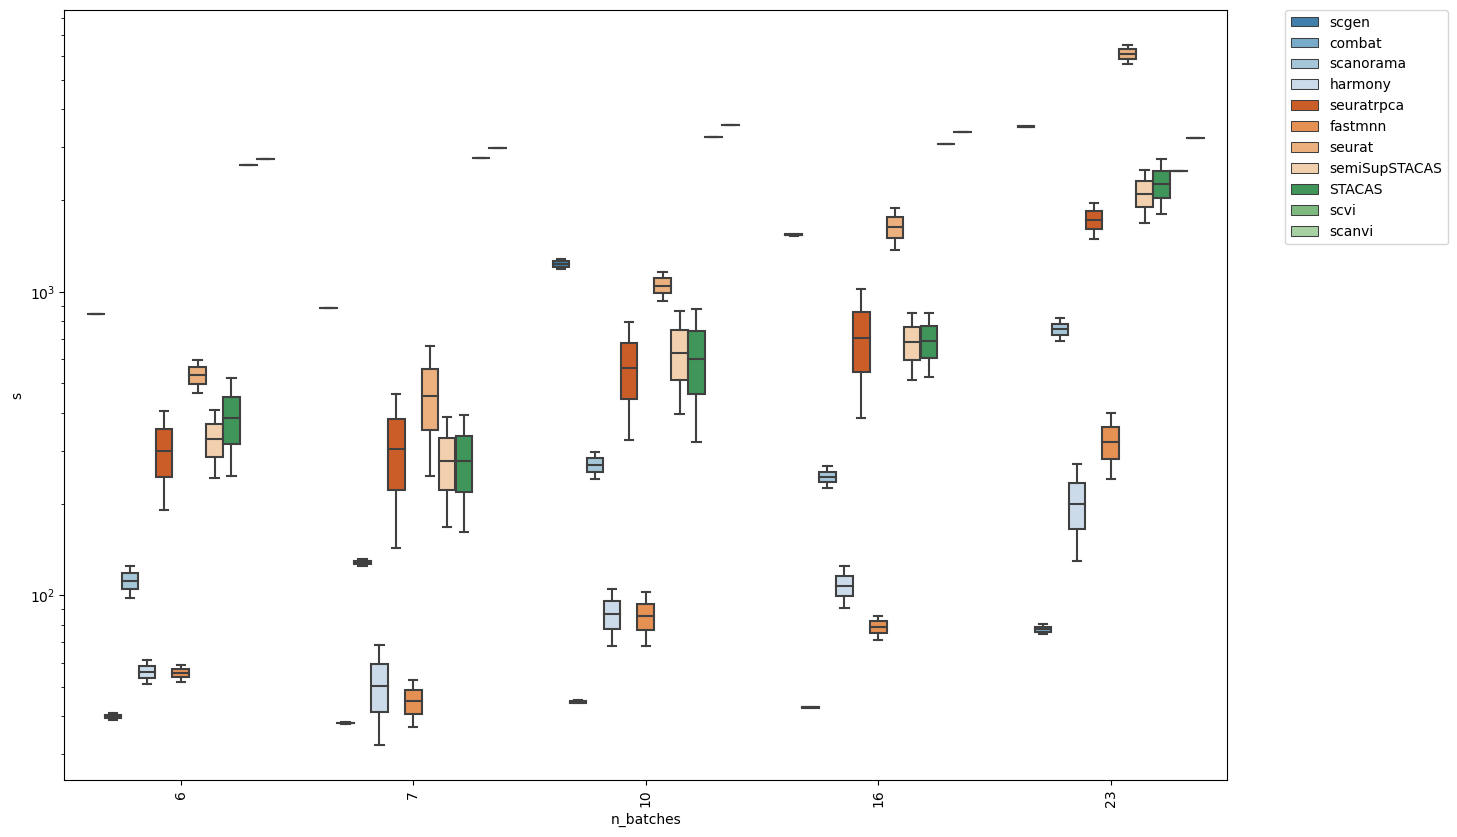

In [45]:
rcParams['figure.figsize']=(15,10)
ax = sb.boxplot(x="n_batches", y="s", hue='method', 
                hue_order=hue_order,
                #order = meta['scenario'][np.argsort(meta['size'])].values,
                data=runs_meta, palette='tab20c')
ax.set(yscale="log")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

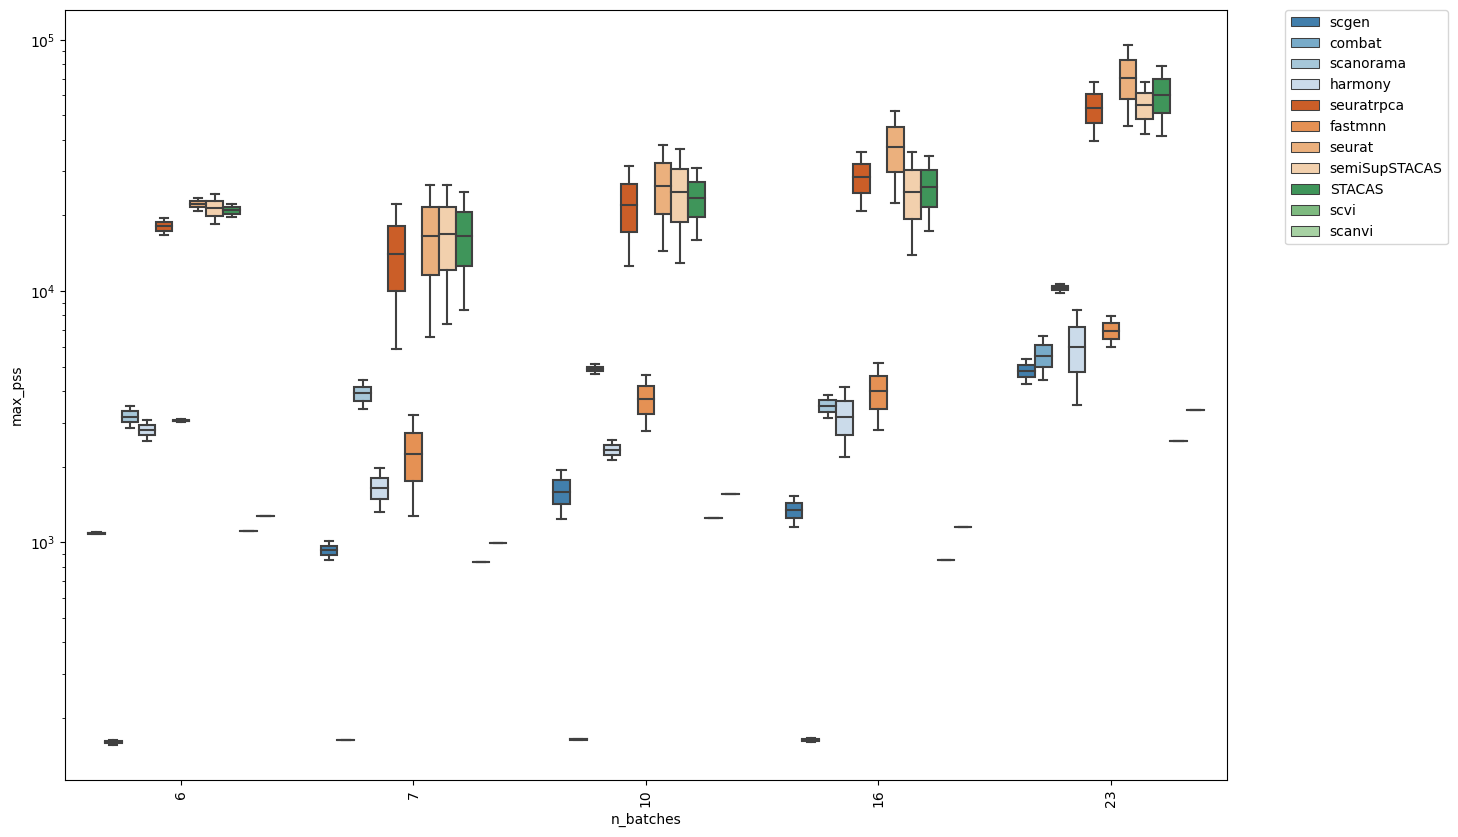

In [46]:
rcParams['figure.figsize']=(15,10)
ax = sb.boxplot(x="n_batches", y="max_pss", hue='method', 
                hue_order=hue_order,
                #order = meta['scenario'][np.argsort(meta['size'])].values,
                data=runs_meta, palette='tab20c')
ax.set(yscale="log")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

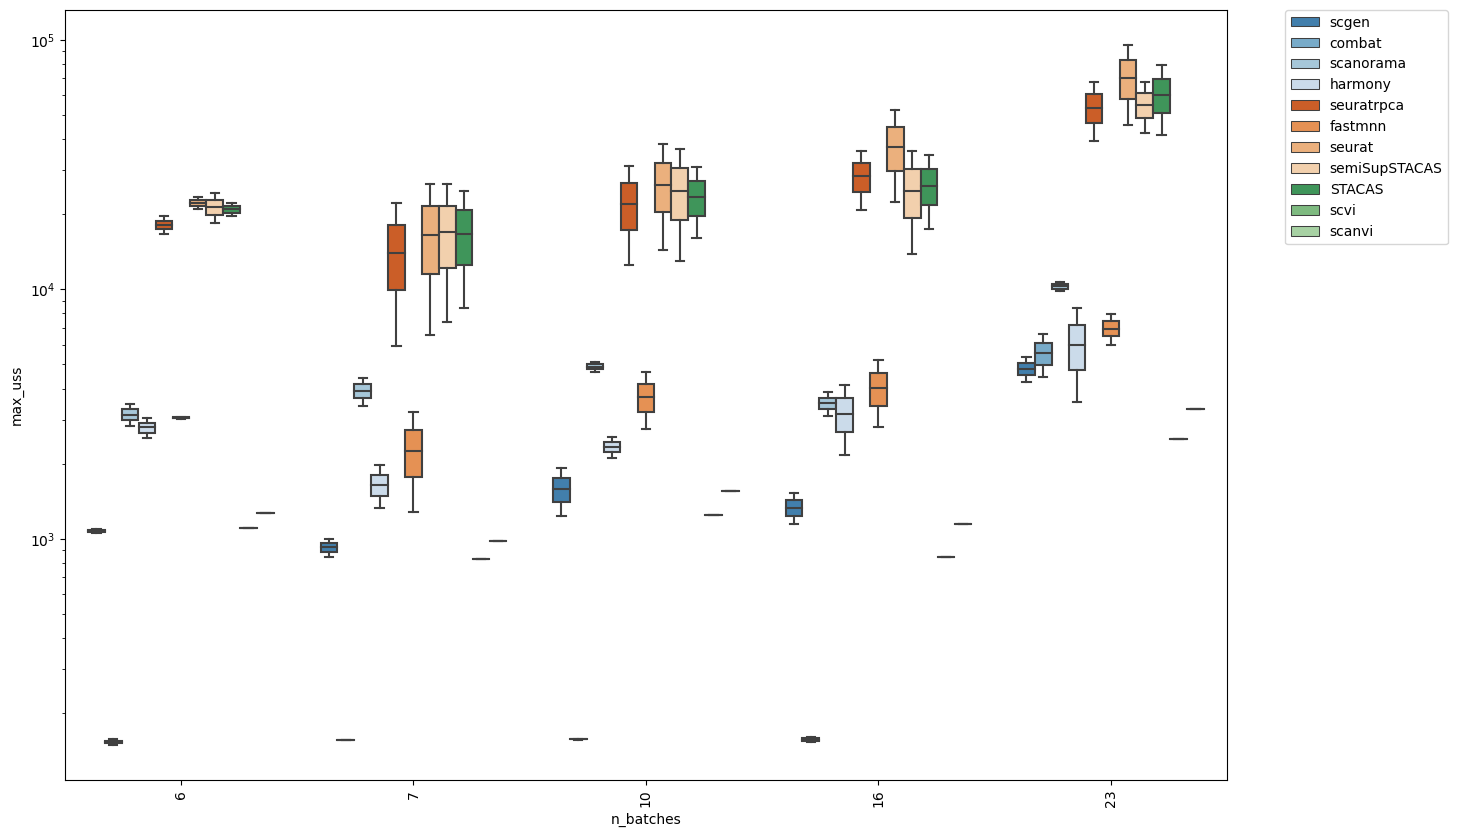

In [47]:
rcParams['figure.figsize']=(15,10)
ax = sb.boxplot(x="n_batches", y="max_uss", hue='method', 
                hue_order=hue_order,
                #order = meta['scenario'][np.argsort(meta['size'])].values,
                data=runs_meta, palette='tab20c')
ax.set(yscale="log")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

## Boxplots per number of features

Visualise runtime and memory use per method and data scenario in a boxplot.

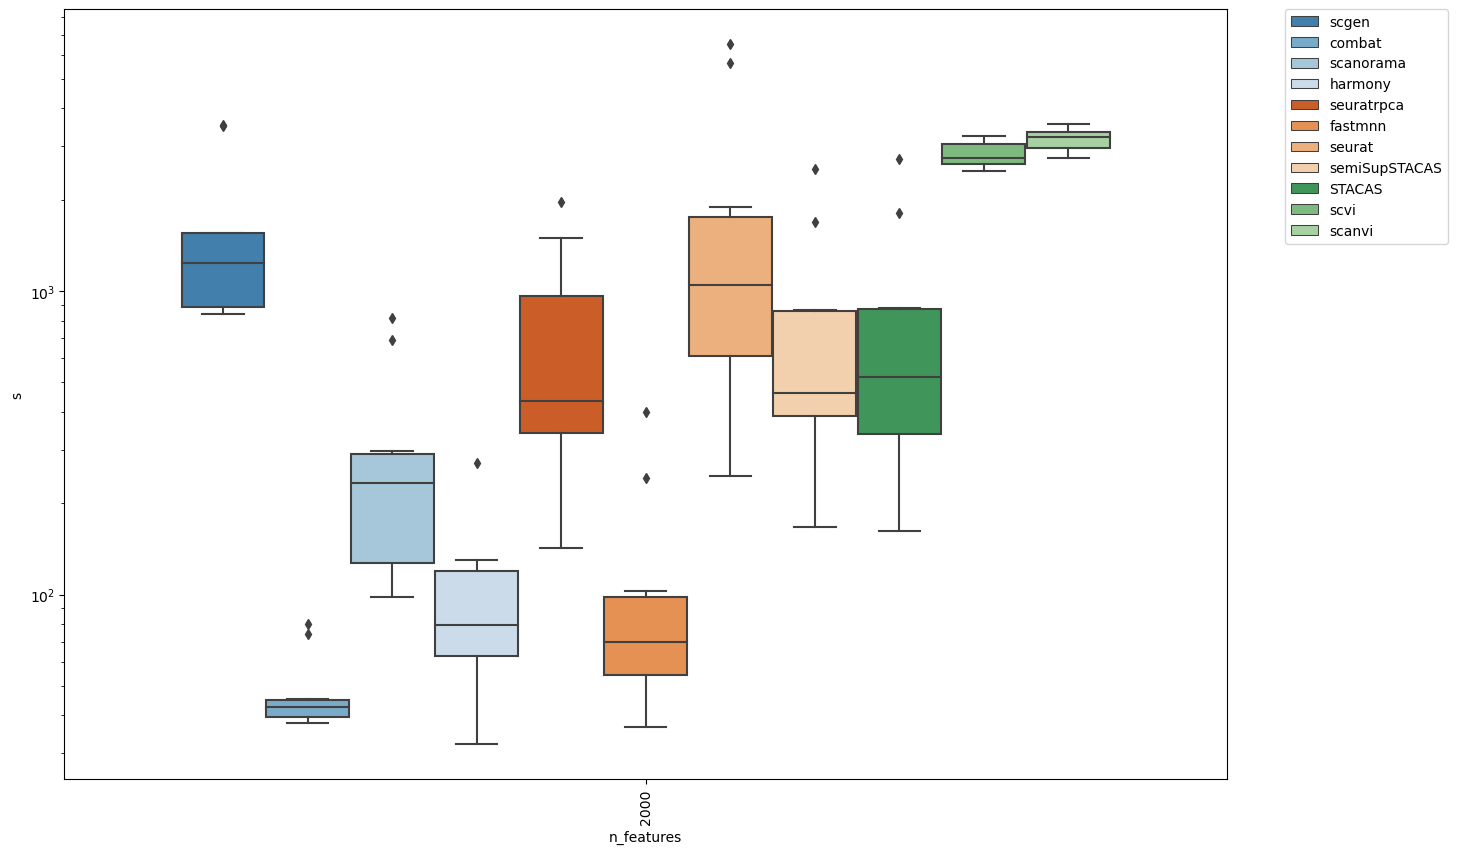

In [48]:
rcParams['figure.figsize']=(15,10)
ax = sb.boxplot(x="n_features", y="s", hue='method', 
                hue_order=hue_order,
                #order = meta['scenario'][np.argsort(meta['size'])].values,
                data=runs_meta, palette='tab20c')
ax.set(yscale="log")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

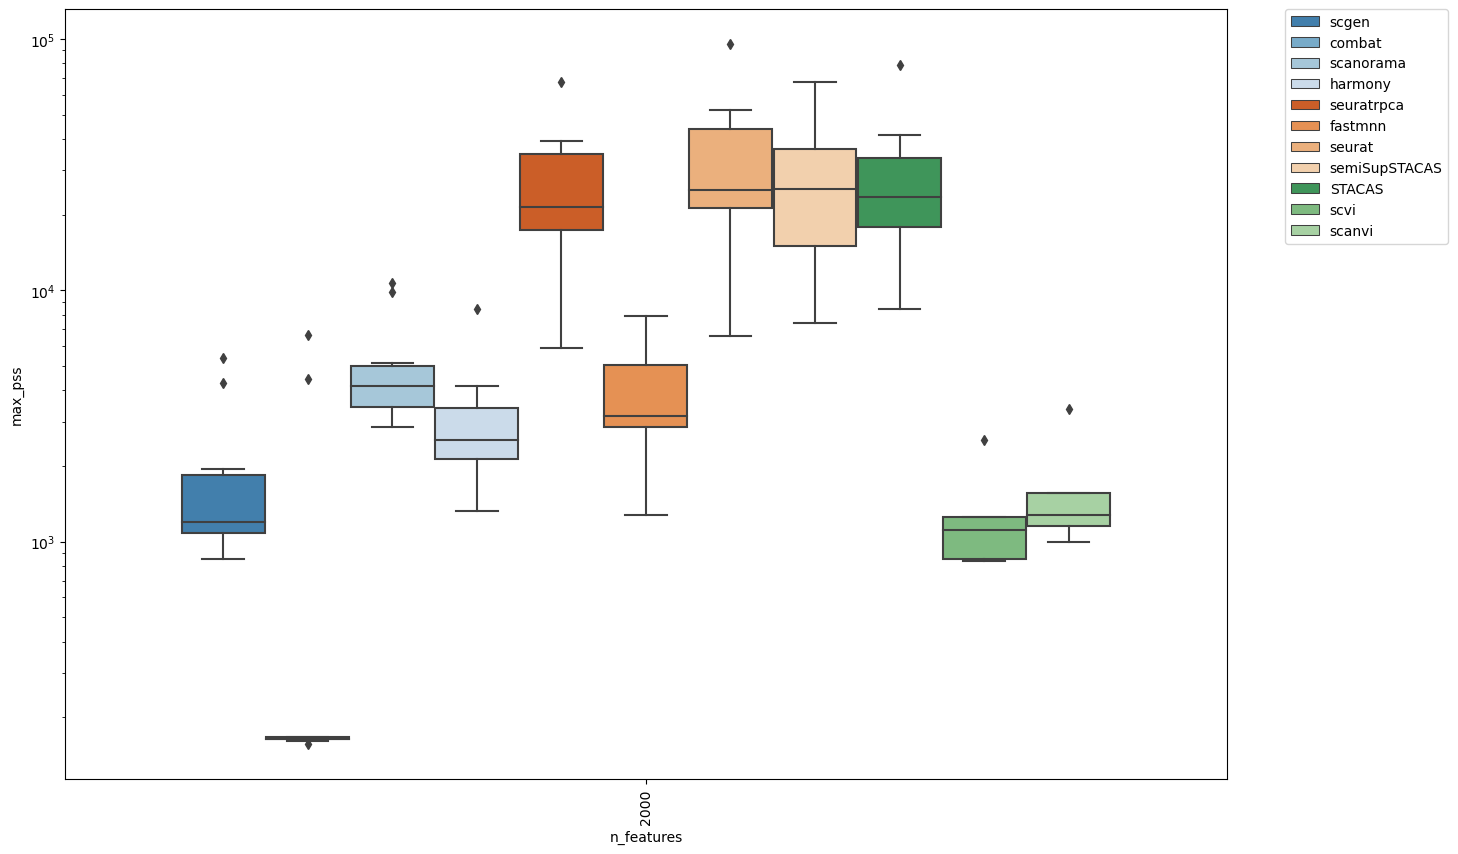

In [49]:
rcParams['figure.figsize']=(15,10)
ax = sb.boxplot(x="n_features", y="max_pss", hue='method', 
                hue_order=hue_order,
                #order = meta['scenario'][np.argsort(meta['size'])].values,
                data=runs_meta, palette='tab20c')
ax.set(yscale="log")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

## Scatterplots per method

Instead of boxplots, we create scatterplots per method to evaluate whether the runtime and memory usage scale log-linearly with the dataset size.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


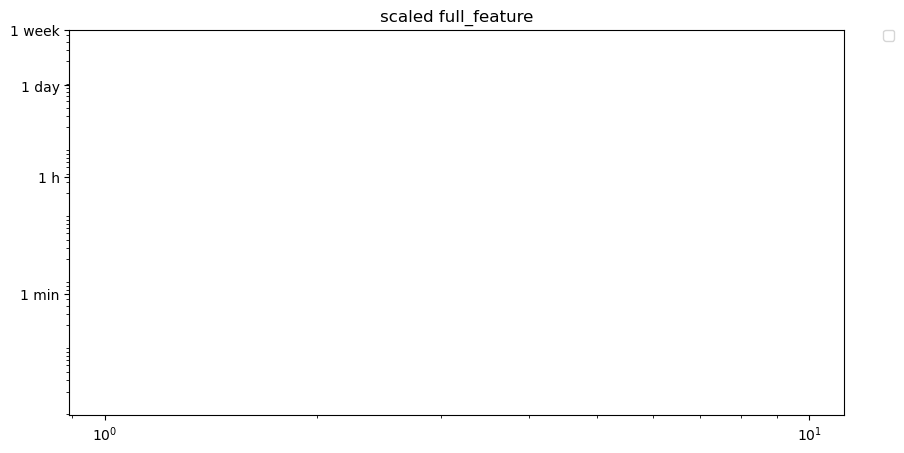

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


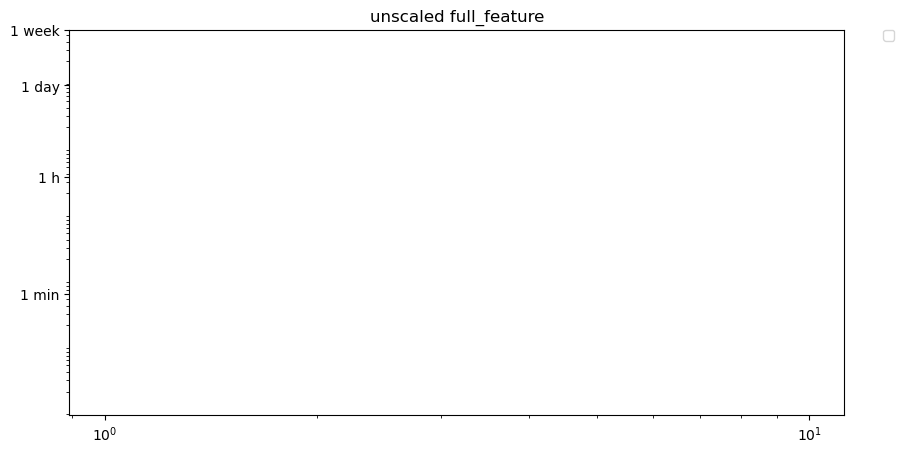

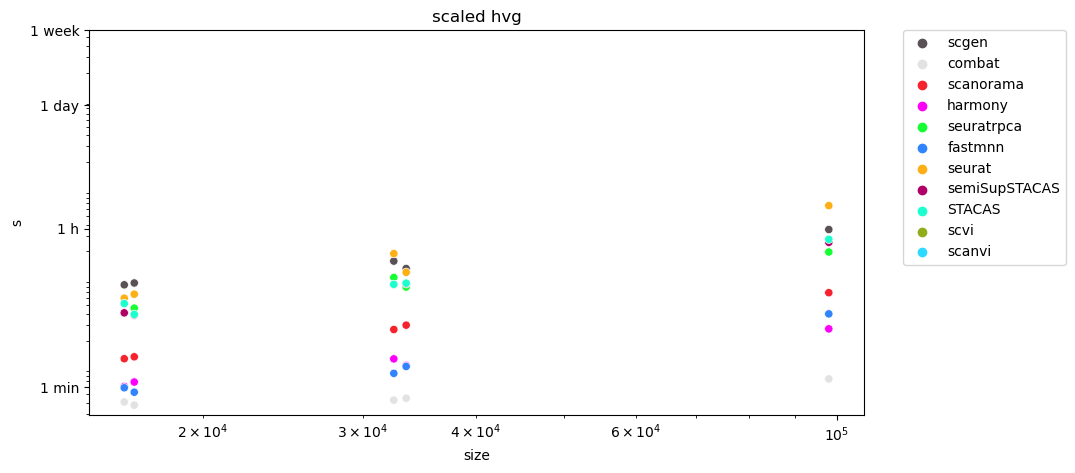

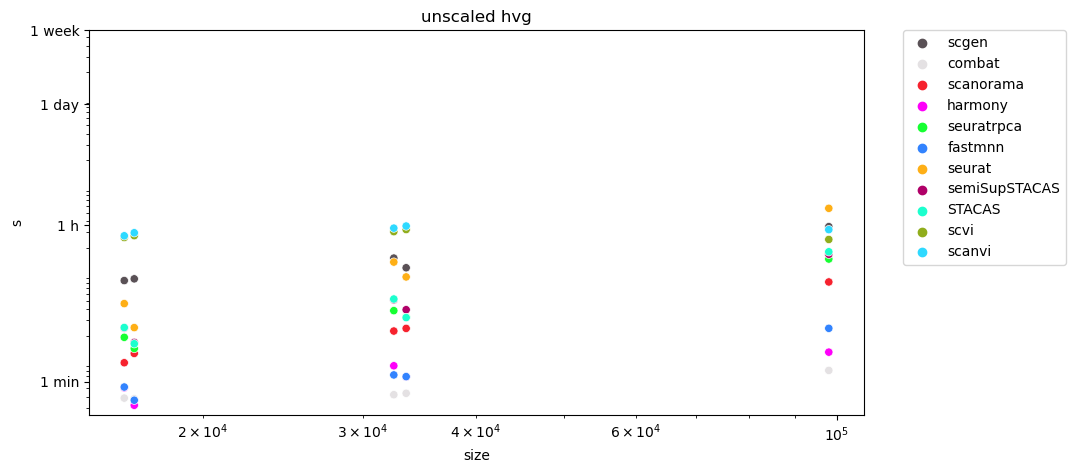

In [50]:


rcParams['figure.figsize'] = (10,5) 
for feat in ['full_feature', 'hvg']:
    for scala in ['scaled', 'unscaled']:
        tmp = runs_meta.loc[np.logical_and(runs_meta['features'] == feat,
                                           runs_meta['scale'] == scala
                                          ), :]
        ax = sb.scatterplot(x="size", y="s", hue='method',
                            hue_order=hue_order,
                        #col='features', row='scale',
                        #order = meta['scenario'][np.argsort(meta['size'])].values,
                        data=tmp)
        ax.set(yscale="log")
        
        plt.yticks([60, 3600, 86400,604800], ['1 min', '1 h', '1 day', '1 week'])
        ax.set(xscale="log")
        ax.set_title(scala + ' ' + feat)
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


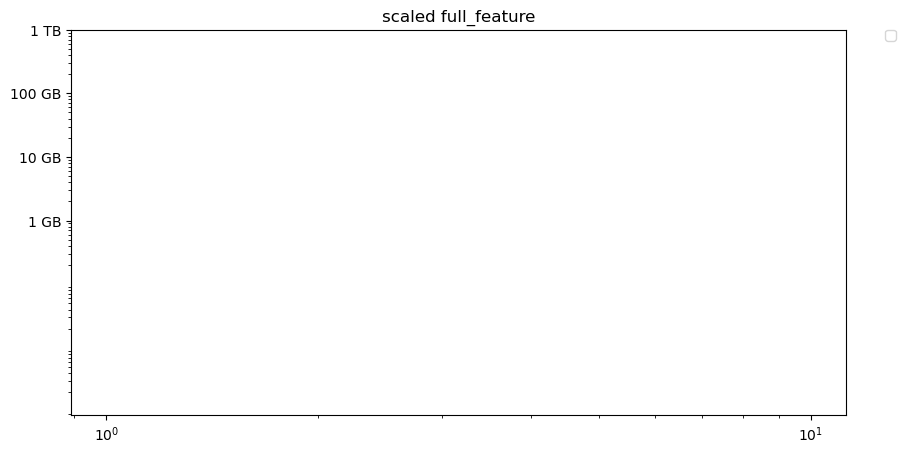

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


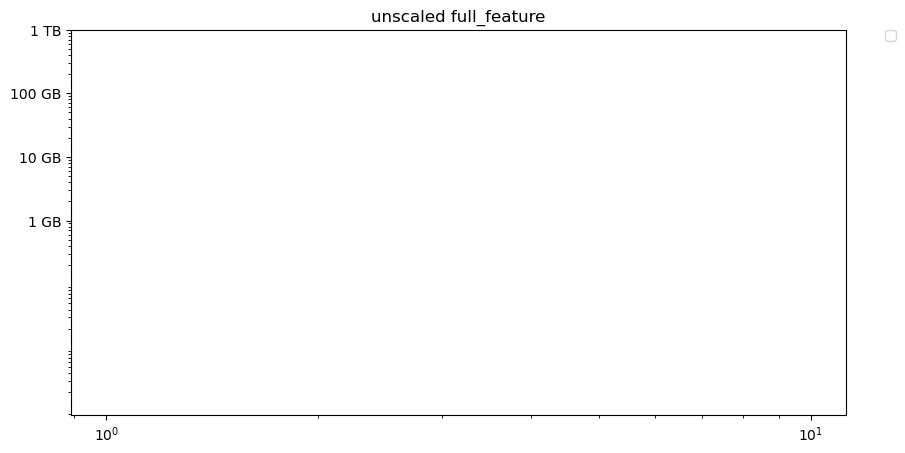

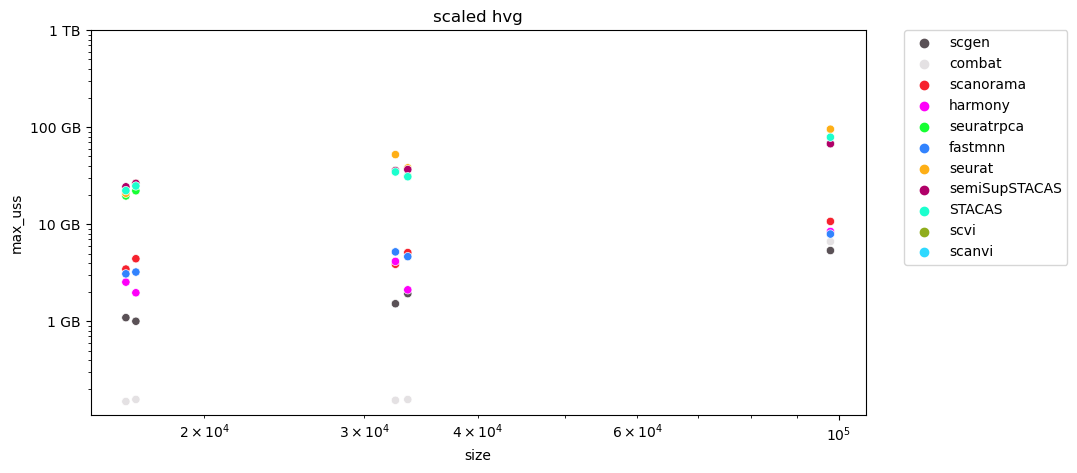

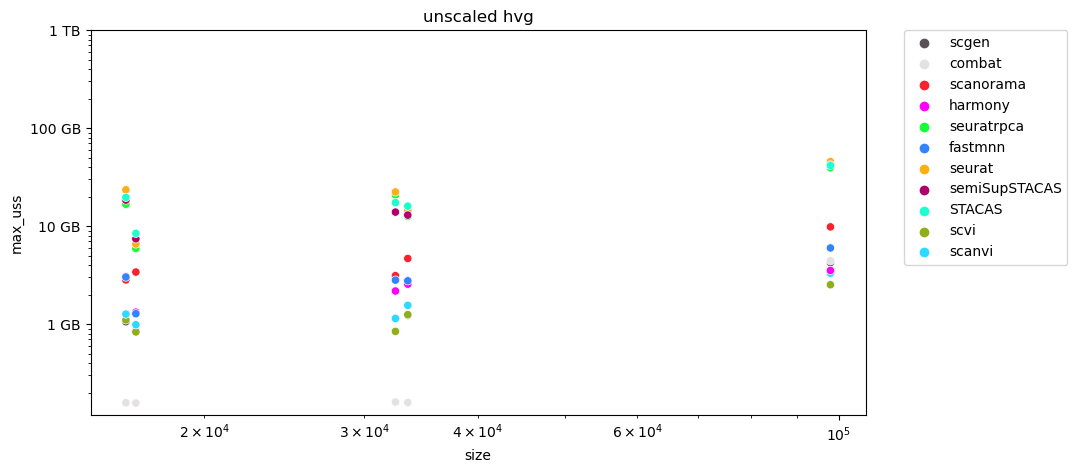

In [51]:
rcParams['figure.figsize'] = (10,5) 
for feat in ['full_feature', 'hvg']:
    for scala in ['scaled', 'unscaled']:
        tmp = runs_meta.loc[np.logical_and(runs_meta['features'] == feat,
                                           runs_meta['scale'] == scala
                                          ), :]
        ax = sb.scatterplot(x="size", y="max_uss", hue='method', 
                            hue_order=hue_order,
                        #col='features', row='scale',
                        #order = meta['scenario'][np.argsort(meta['size'])].values,
                        data=tmp)
        ax.set(yscale="log") 
        plt.yticks([1e3, 1e4, 1e5, 1e6], ['1 GB', '10 GB', '100 GB', '1 TB'])
        ax.set(xscale="log")
        ax.set_title(scala + ' ' + feat)
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


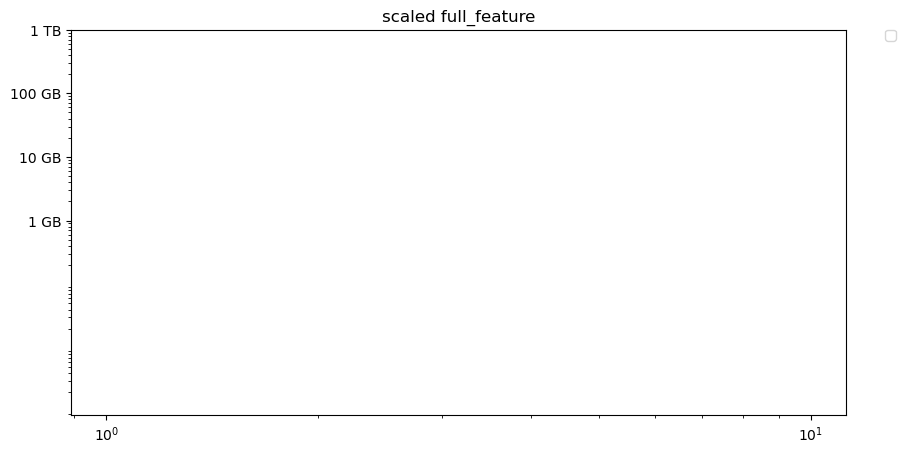

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


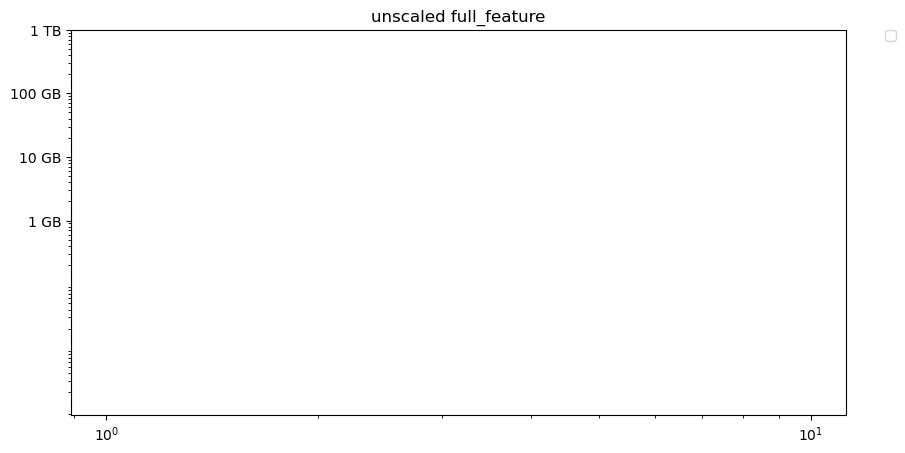

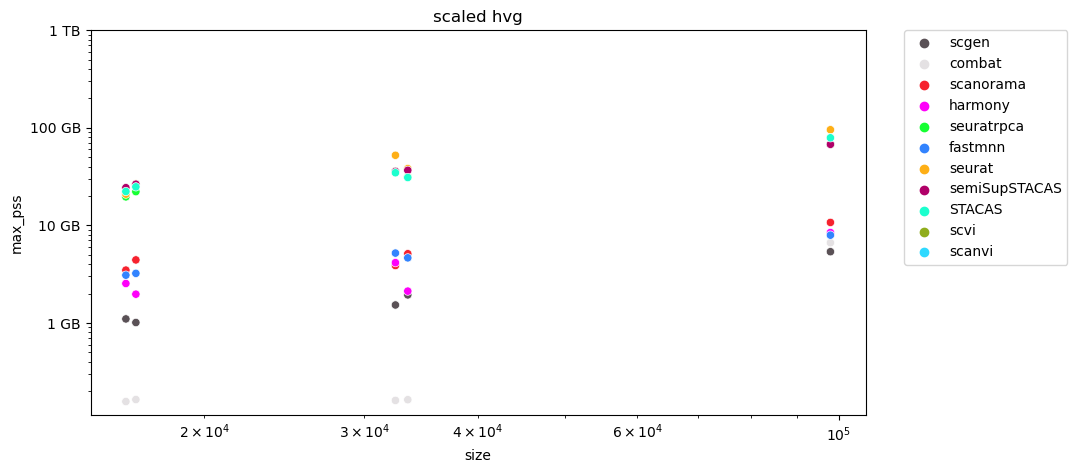

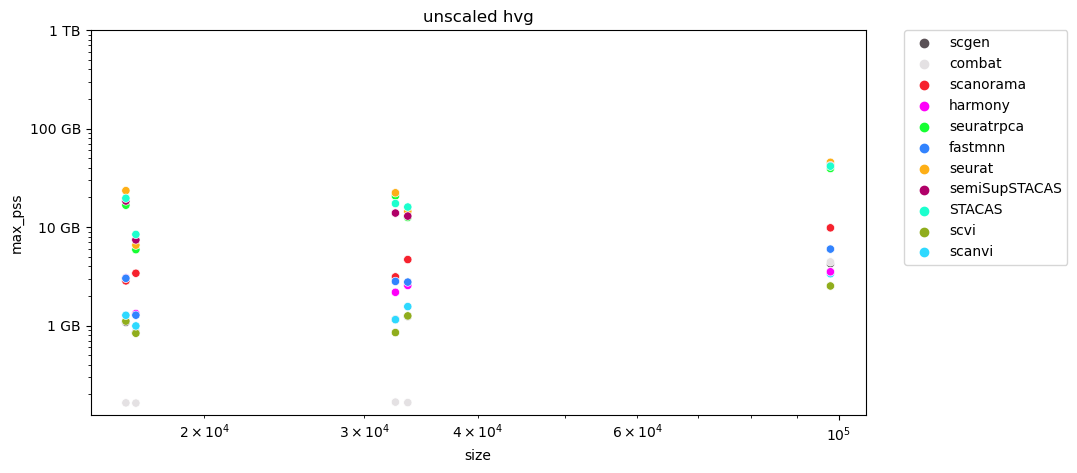

In [52]:
rcParams['figure.figsize'] = (10,5) 
for feat in ['full_feature', 'hvg']:
    for scala in ['scaled', 'unscaled']:
        tmp = runs_meta.loc[np.logical_and(runs_meta['features'] == feat,
                                           runs_meta['scale'] == scala
                                          ), :]
        ax = sb.scatterplot(x="size", y="max_pss", hue='method', 
                            hue_order=hue_order,
                        #col='features', row='scale',
                        #order = meta['scenario'][np.argsort(meta['size'])].values,
                        data=tmp)
        ax.set(yscale="log") 
        plt.yticks([1e3, 1e4, 1e5, 1e6], ['1 GB', '10 GB', '100 GB', '1 TB'])
        ax.set(xscale="log")
        ax.set_title(scala + ' ' + feat)
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        plt.show()

In order to decide which memory measurement to show in the manuscript, let us visualise `max_pss` and `max_uss` in a scatter plot.

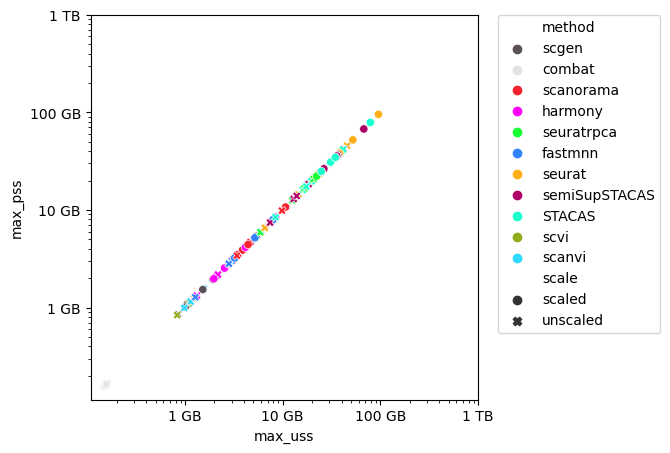

In [53]:
rcParams['figure.figsize']=(5,5)
ax = sb.scatterplot(x="max_uss", y="max_pss", hue='method', 
                            hue_order=hue_order,
                    style = 'scale',
                        #col='features', row='scale',
                        #order = meta['scenario'][np.argsort(meta['size'])].values,
                        data=runs_meta)
ax.set(yscale="log") 
plt.yticks([1e3, 1e4, 1e5, 1e6], ['1 GB', '10 GB', '100 GB', '1 TB'])
ax.set(xscale="log")
plt.xticks([1e3, 1e4, 1e5, 1e6], ['1 GB', '10 GB', '100 GB', '1 TB'])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

Compute the correlation of `max_pss` and `max_uss`.

In [54]:
runs_meta['max_pss'].corr(runs_meta['max_uss'])

0.9999999137944693

Out of curiosity: How does `max_rss` behave compared to `max_uss`?

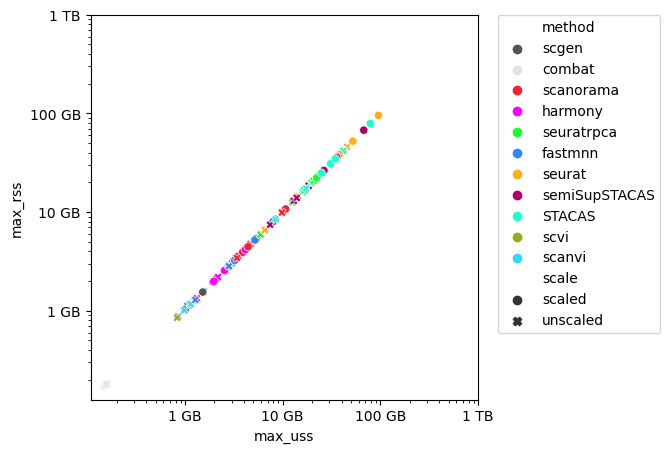

In [55]:
rcParams['figure.figsize']=(5,5)
ax = sb.scatterplot(x="max_uss", y="max_rss", hue='method', 
                            hue_order=hue_order,
                    style = 'scale',
                        #col='features', row='scale',
                        #order = meta['scenario'][np.argsort(meta['size'])].values,
                        data=runs_meta)
ax.set(yscale="log") 
plt.yticks([1e3, 1e4, 1e5, 1e6], ['1 GB', '10 GB', '100 GB', '1 TB'])
ax.set(xscale="log")
plt.xticks([1e3, 1e4, 1e5, 1e6], ['1 GB', '10 GB', '100 GB', '1 TB'])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [56]:
runs_meta['max_rss'].corr(runs_meta['max_uss'])

0.9999972465696767

## Fit function to data

In order to determine a scalability score for each method, we fit a linear function to the data time or memory needed vs. data scenario size.

To determine a score, we use the estimated parameters to compute the area under the curve (integral of the time/memory needed).  

In [57]:
import scipy

In [58]:
from scipy.optimize import curve_fit

In [59]:
scipy.__version__

'1.6.0'

In [60]:
def func(x, a, b):
    return a * x + b

### Fit every variation separately

Create a data frame to store all results.

In [61]:
fit_params_time = pd.DataFrame({'method':[], 
                           'features': [], 'scale': [], 
                           'mse_lin' : [],
                           'slope_a': [], 'intercept_b': []   
                          })

fit_params_memory = pd.DataFrame({'method':[], 
                           'features': [], 'scale': [], 
                           'mse_lin' : [],
                           'slope_a': [], 'intercept_b': [] 
                          })

fit_memory_time = pd.DataFrame({'scenario':[],
                                'method':[], 
                                'features': [], 
                                'scale': [], 
                                'size' : [], 
                                's_pred_lin': [], 
                                'memory_pred_lin': [],
                               })

Run fits for all scenarios and variations.

In [62]:
for feat in ['full_feature', 'hvg']:
    for scala in ['scaled', 'unscaled']:
        if feat == 'full_feature': #exclude atac peaks and windows
            tmp = runs_meta.loc[np.logical_and(runs_meta['features'] == feat,
                                           runs_meta['scale'] == scala
                                          ), :]
            tmp = tmp.loc[np.invert(np.in1d(tmp['scenario1'], ['mouse_brain_atac_peaks_large',
                   'mouse_brain_atac_peaks_small', 'mouse_brain_atac_windows_large',
                   'mouse_brain_atac_windows_small'])),:]
        else:
            tmp = runs_meta.loc[np.logical_and(runs_meta['features'] == feat,
                                           runs_meta['scale'] == scala
                                          ), :]
        for method in np.unique(tmp['method']):
            tmp_meth = tmp.loc[tmp['method']== method,:]
            xdata = np.log(tmp_meth['size'])
            ydata = np.log(tmp_meth['s'])
            ydata2 = np.log(tmp_meth['max_pss'])
            if len(xdata)<2:
                continue
            else:
                #fit time relation
                popt, pcov = curve_fit(func, xdata, ydata)
                y_pred = func(xdata, *popt)
                mse = np.mean((y_pred - ydata)**2)
                fit_params_time = fit_params_time.append({'method': method, 
                               'features': feat, 'scale': scala, 
                               'mse_lin' : mse,
                               'slope_a': popt[0], 'intercept_b': popt[1], 
                                      }, ignore_index=True)
                
                tmp_meth['s_pred_lin'] = np.exp(y_pred)
                
                #fit memory relation
                popt, pcov = curve_fit(func, xdata, ydata2)
                y_pred = func(xdata, *popt)
                mse = np.mean((y_pred - ydata)**2)
                fit_params_memory = fit_params_memory.append({'method': method, 
                               'features': feat, 'scale': scala, 
                               'mse_lin' : mse,
                               'slope_a': popt[0], 'intercept_b': popt[1], 
                           }, ignore_index=True)
                tmp_meth['memory_pred_lin'] = np.exp(y_pred)

                fit_memory_time = fit_memory_time.append(tmp_meth[[
                                'scenario','method',
                                'features', 'scale', 'size', 
                                's_pred_lin',  
                                'memory_pred_lin']])

<ipython-input-62-7cbe06aa8c0f>:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fit_params_time = fit_params_time.append({'method': method,
<ipython-input-62-7cbe06aa8c0f>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_meth['s_pred_lin'] = np.exp(y_pred)
<ipython-input-62-7cbe06aa8c0f>:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fit_params_memory = fit_params_memory.append({'method': method,
<ipython-input-62-7cbe06aa8c0f>:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] 

<ipython-input-62-7cbe06aa8c0f>:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fit_memory_time = fit_memory_time.append(tmp_meth[[
<ipython-input-62-7cbe06aa8c0f>:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fit_params_time = fit_params_time.append({'method': method,
<ipython-input-62-7cbe06aa8c0f>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_meth['s_pred_lin'] = np.exp(y_pred)
<ipython-input-62-7cbe06aa8c0f>:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fit_param

<ipython-input-62-7cbe06aa8c0f>:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fit_params_memory = fit_params_memory.append({'method': method,
<ipython-input-62-7cbe06aa8c0f>:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_meth['memory_pred_lin'] = np.exp(y_pred)
<ipython-input-62-7cbe06aa8c0f>:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fit_memory_time = fit_memory_time.append(tmp_meth[[
<ipython-input-62-7cbe06aa8c0f>:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  

In [63]:
another_test = runs_meta.merge(fit_memory_time, on='scenario')

In [64]:
another_test.columns

Index(['scenario1', 'call', 'scale_x', 'features_x', 'method_x', 'scenario',
       'size_x', 'n_batches', 'n_features', 'scenario_type', 's', 'h_m_s',
       'max_rss', 'max_vms', 'max_uss', 'max_pss', 'io_in', 'io_out',
       'mean_load', 'cpu_time', 'method_y', 'features_y', 'scale_y', 'size_y',
       's_pred_lin', 'memory_pred_lin'],
      dtype='object')

#### Linear fit

Comment: Here, we plot the results of a linear fit without error bars.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


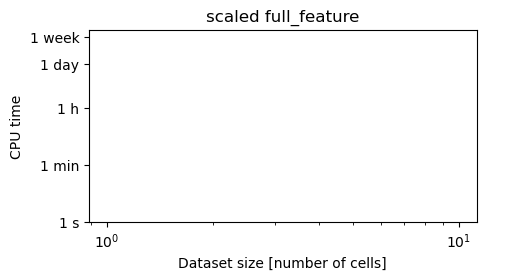

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


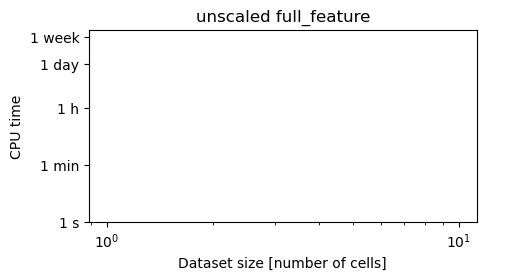

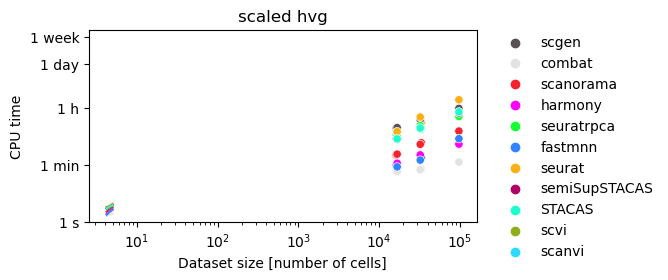

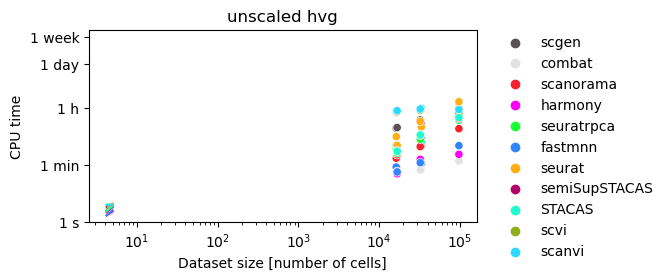

In [65]:
rcParams['figure.figsize'] = (5,2.5) 


for feat in ['full_feature', 'hvg']:
    for scala in ['scaled', 'unscaled']:
        tmp = another_test.loc[np.logical_and(another_test['features_x'] == feat,
                                           another_test['scale_x'] == scala
                                          ), :]
        ax = sb.scatterplot(x="size_x", y="s", hue='method_x',
                            hue_order=hue_order,
                            legend='brief',
                        #col='features', row='scale',
                        #order = meta['scenario'][np.argsort(meta['size'])].values,
                        data=tmp)
        ax.set(yscale="log") 
        ax.set(xscale="log")
        ax.set_title(scala + ' ' + feat)
        sb.lineplot(x='size_x', y='s_pred_lin', 
                    hue_order=hue_order,
                        legend = False,
                    hue='method_y', data=tmp, 
                       # palette='tab20c',
                    ax=ax)
        ax.set_xlabel('Dataset size [number of cells]')
        ax.set_ylabel('CPU time')
        ax.set_ylim([1, 1e6])
        plt.yticks([1, 60, 3600, 86400,604800], ['1 s', '1 min', '1 h', '1 day', '1 week'])
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., frameon=False)
        #plt.savefig('./../figures/time_' +scala + '_' + feat + '_revision.pdf', bbox_inches='tight')
        plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


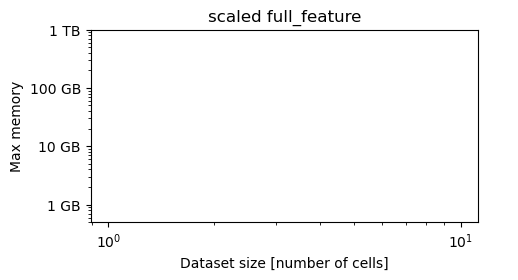

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


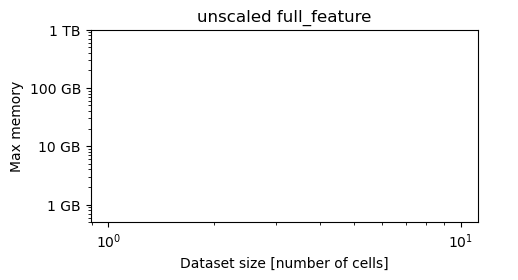

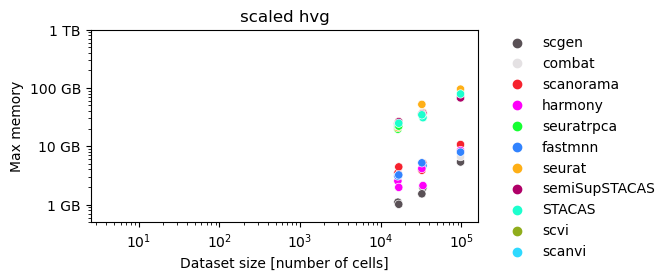

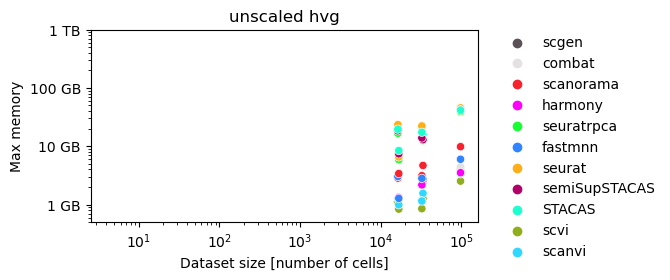

In [66]:
rcParams['figure.figsize'] = (5,2.5) 
for feat in ['full_feature', 'hvg']:
    for scala in ['scaled', 'unscaled']:
        tmp = another_test.loc[np.logical_and(another_test['features_x'] == feat,
                                           another_test['scale_x'] == scala
                                          ), :]
        ax = sb.scatterplot(x="size_x", y="max_pss", hue='method_x',
                            hue_order=hue_order,
                            legend='brief',
                        #col='features', row='scale',
                        #order = meta['scenario'][np.argsort(meta['size'])].values,
                        data=tmp)
        ax.set(yscale="log") 
        ax.set(xscale="log")
        ax.set_title(scala + ' ' + feat)
        sb.lineplot(x='size_x', y='memory_pred_lin', 
                    hue_order=['bbknn', 'conos', 
                           'trvae', 'scvi', 'desc', 'saucie','scgen', 'scanvi', 
                                       'combat',
                           'harmony', 'liger', 'scanorama','mnn', 'fastmnn',
                           'seurat','seuratrpca'],
                        legend = False,
                    hue='method_y', data=tmp, 
                        #palette='tab20c',
                    ax=ax)
        ax.set_xlabel('Dataset size [number of cells]')
        ax.set_ylabel('Max memory')
        ax.set_ylim([500, 1e6])
        plt.yticks([1e3, 1e4, 1e5, 1e6], ['1 GB', '10 GB', '100 GB', '1 TB'])
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., frameon=False)
        #plt.savefig('./../figures/memory_' +scala + '_' + feat + '_revision.pdf', bbox_inches='tight')
        plt.show()

#### Compute scalability score

In order to derive a scalability score for each method, we compute the area under the fit curve and scale it with the area of a rectangle of the size 10^6-10^4 (size of largest dataset) and 10^8 s (in the time case, approximately equal to 24.1 days computation time on 48 cores). 

## Adaptation 
in our case the largest dataset size is 10⁵

In [67]:
f_A = fit_params_time['slope_a']*np.log(10**4) + fit_params_time['intercept_b']

In [68]:
f_B = fit_params_time['slope_a']*np.log(10**5) + fit_params_time['intercept_b']

In [69]:
fit_params_time['AUC'] = 0.5*(np.log(10**5)-np.log(10**4))*(f_B+f_A)

In [70]:
fit_params_time['AUC_scaled'] = 1 - 0.5*(f_B+f_A)/np.log(10**8)

In [71]:
fit_params_time['metrics'] = [fit_params_time['scale'][idx[0]] + '/' + fit_params_time['features'][idx[0]] + '/' + fit_params_time['method'][idx[0]] for idx in enumerate(fit_params_time['method'])]

In [72]:
fit_for_file2 = fit_params_time[['metrics', 'AUC', 'AUC_scaled']]

In [73]:
fit_for_file2.to_csv('./scalability_score_time_revision.csv')

In [74]:
fit_for_file2

,metrics,AUC,AUC_scaled
0,scaled/hvg/STACAS,15.540947,0.633599
1,scaled/hvg/combat,8.865021,0.790994
2,scaled/hvg/fastmnn,10.682084,0.748154
3,scaled/hvg/harmony,10.815004,0.745020
4,scaled/hvg/scanorama,12.707316,0.700406
5,scaled/hvg/scgen,16.695485,0.606380
6,scaled/hvg/semiSupSTACAS,15.376728,0.637471
7,scaled/hvg/seurat,16.749659,0.605102
8,scaled/hvg/seuratrpca,15.380009,0.637394
9,unscaled/hvg/STACAS,13.915122,0.671931


We do the same for memory. Here, we use 10^7 MB as maximum (which corresponds to 10 TB). We derived the power `d` of this value such that the maximum of `0.5*(f_A + f_B)` is definitely smaller than `np.log(10**d)`. 

Same adaptation as before

In [75]:
f_A = fit_params_memory['slope_a']*np.log(10**4) + fit_params_memory['intercept_b']

In [76]:
f_B = fit_params_memory['slope_a']*np.log(10**5) + fit_params_memory['intercept_b']

In [77]:
fit_params_memory['AUC'] = 0.5*(np.log(10**5)-np.log(10**4))*(f_B+f_A)

In [78]:
fit_params_memory['AUC_scaled'] = 1 - 0.5*(f_B+f_A)/np.log(10**7)

In [79]:
fit_params_memory['metrics'] = [fit_params_memory['scale'][idx[0]] + '/' + fit_params_memory['features'][idx[0]] + '/' + fit_params_memory['method'][idx[0]] for idx in enumerate(fit_params_memory['method'])]

In [80]:
fit_for_file = fit_params_memory[['metrics', 'AUC', 'AUC_scaled']]

In [81]:
fit_for_file['AUC_scaled'].max() - fit_for_file['AUC_scaled'].min()

0.2991225112485554

In [82]:
fit_for_file

,metrics,AUC,AUC_scaled
0,scaled/hvg/STACAS,24.058657,0.351751
1,scaled/hvg/combat,13.487040,0.636598
2,scaled/hvg/fastmnn,19.401811,0.477227
3,scaled/hvg/harmony,18.655550,0.497335
4,scaled/hvg/scanorama,19.651786,0.470492
5,scaled/hvg/scgen,17.259937,0.534939
6,scaled/hvg/semiSupSTACAS,24.146529,0.349383
7,scaled/hvg/seurat,24.438920,0.341505
8,scaled/hvg/seuratrpca,23.900285,0.356018
9,unscaled/hvg/STACAS,22.589446,0.391338


In [83]:
fit_for_file.to_csv('./scalability_score_memory_revision.csv')

## Examine the influence of the number of features on runtime and memory usage

In [84]:
import statsmodels

In [85]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [86]:
statsmodels.__version__

'0.13.2'

Split by scaling and by method.

In [87]:
fit_params_time = pd.DataFrame({'method':[],  'scale' :[],
                           'slope_n_features' : [],
                           'slope_size': [], 'intercept_b': [], 
                                'pval_n_features' : [],
                           'pval_size': [], 'pval_intercept_b': []  
                          })

fit_params_memory = pd.DataFrame({'method':[],  'scale' : [],
                           'slope_n_features': [], 
                           'slope_size': [], 'intercept_b': [] ,
                                   'pval_n_features' : [],
                           'pval_size': [], 'pval_intercept_b': []  
                          })


In [88]:

for scala in ['scaled', 'unscaled']:

    tmp = runs_meta.loc[runs_meta['scale'] == scala
                                          , :]
    for method in np.unique(tmp['method']):
        tmp_meth = tmp.loc[tmp['method']== method,:]
        tmp_meth['size'] = np.log(tmp_meth['size'])
        tmp_meth['s'] = np.log(tmp_meth['s'])
        tmp_meth['max_pss'] = np.log(tmp_meth['max_pss'])
        tmp_meth['n_features'] = np.log(tmp_meth['n_features'])
        if len(tmp_meth)<2:
            continue
        else:
            #fit runtime relation
            mod = smf.ols(formula='s ~ size + n_features', data=tmp_meth)
            res = mod.fit()
        
            fit_params_time = fit_params_time.append({'method': method, 'scale' :scala,
                               'slope_n_features' : res.params[2],
                               'slope_size': res.params[1], 'intercept_b': res.params[0], 
                                                  'pval_n_features' : res.pvalues[2],
                           'pval_size': res.pvalues[1], 'pval_intercept_b': res.pvalues[0]
                                      }, ignore_index=True)
               
                                
                          
            #fit memory relation
            mod = smf.ols(formula='max_pss ~ size + n_features', data=tmp_meth)
            res = mod.fit()
        
            fit_params_memory = fit_params_memory.append({'method': method,  'scale' :scala,
                               'slope_n_features' : res.params[2],
                               'slope_size': res.params[1], 'intercept_b': res.params[0], 
                                                  'pval_n_features' : res.pvalues[2],
                           'pval_size': res.pvalues[1], 'pval_intercept_b': res.pvalues[0]
                           }, ignore_index=True)

<ipython-input-88-b921a26712b6>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_meth['size'] = np.log(tmp_meth['size'])
<ipython-input-88-b921a26712b6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_meth['s'] = np.log(tmp_meth['s'])
<ipython-input-88-b921a26712b6>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

<ipython-input-88-b921a26712b6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_meth['s'] = np.log(tmp_meth['s'])
<ipython-input-88-b921a26712b6>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_meth['max_pss'] = np.log(tmp_meth['max_pss'])
<ipython-input-88-b921a26712b6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

<ipython-input-88-b921a26712b6>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_meth['size'] = np.log(tmp_meth['size'])
<ipython-input-88-b921a26712b6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_meth['s'] = np.log(tmp_meth['s'])
<ipython-input-88-b921a26712b6>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

<ipython-input-88-b921a26712b6>:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fit_params_memory = fit_params_memory.append({'method': method,  'scale' :scala,
<ipython-input-88-b921a26712b6>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_meth['size'] = np.log(tmp_meth['size'])
<ipython-input-88-b921a26712b6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_meth['s'] = np.log(tmp_meth['s'])
<ipython-input-8

In [89]:
fit_params_memory['log10p_n_features'] = -np.log10(fit_params_memory['pval_n_features'])
fit_params_memory['log10p_size'] = -np.log10(fit_params_memory['pval_size'])

In [90]:
fit_params_time['log10p_n_features'] = -np.log10(fit_params_time['pval_n_features'])
fit_params_time['log10p_size'] = -np.log10(fit_params_time['pval_size'])

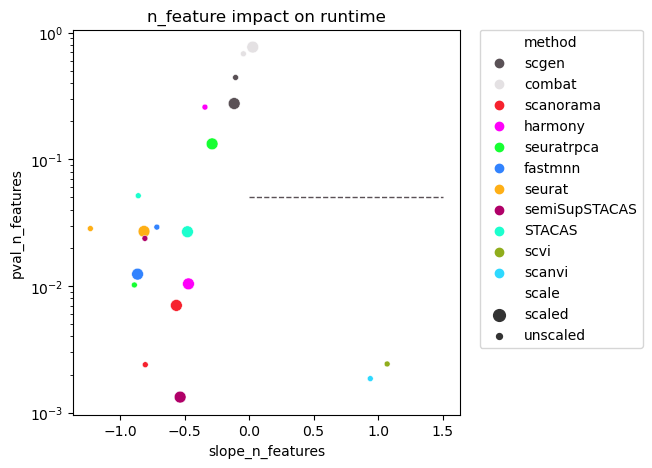

In [91]:
rcParams['figure.figsize'] = (5,5) 

ax = sb.scatterplot(x="slope_n_features", y="pval_n_features", hue='method', size='scale',
                            hue_order=hue_order,
                        #col='features', row='scale',
                        #order = meta['scenario'][np.argsort(meta['size'])].values,
                        data=fit_params_time)
ax.set(yscale="log") 
        #plt.yticks([1e3, 1e4, 1e5, 1e6], ['1 GB', '10 GB', '100 GB', '1 TB'])
        #ax.set(xscale="log")
ax.set_title('n_feature impact on runtime')
plt.plot([0, 1.5], [0.05, 0.05], linewidth=1, linestyle='--')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

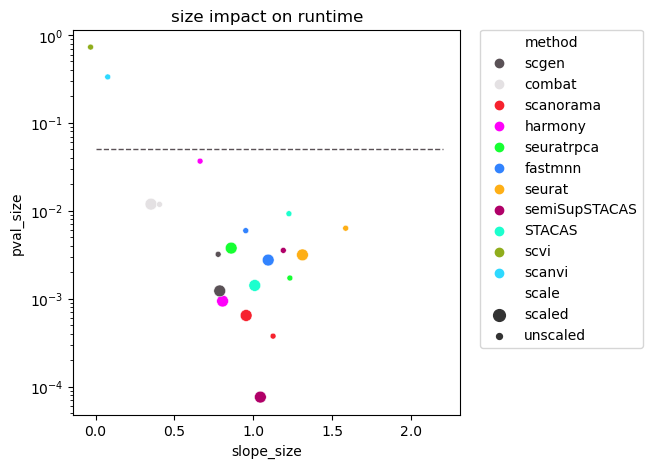

In [92]:
rcParams['figure.figsize'] = (5,5) 

ax = sb.scatterplot(x="slope_size", y="pval_size", hue='method', size='scale',
                            hue_order=hue_order,
                        #col='features', row='scale',
                        #order = meta['scenario'][np.argsort(meta['size'])].values,
                        data=fit_params_time)
ax.set(yscale="log") 
        #plt.yticks([1e3, 1e4, 1e5, 1e6], ['1 GB', '10 GB', '100 GB', '1 TB'])
        #ax.set(xscale="log")
ax.set_title('size impact on runtime')
plt.plot([0, 2.2], [0.05, 0.05], linewidth=1, linestyle='--')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

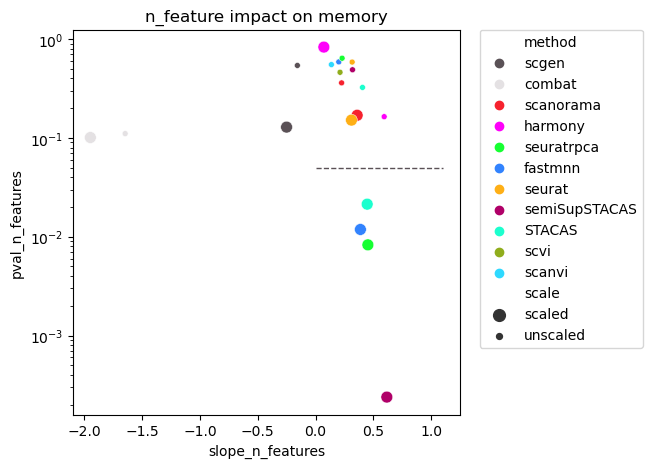

In [93]:
rcParams['figure.figsize'] = (5,5) 

ax = sb.scatterplot(x="slope_n_features", y="pval_n_features", hue='method', size='scale',
                            hue_order=hue_order,
                        #col='features', row='scale',
                        #order = meta['scenario'][np.argsort(meta['size'])].values,
                        data=fit_params_memory)
ax.set(yscale="log") 
        #plt.yticks([1e3, 1e4, 1e5, 1e6], ['1 GB', '10 GB', '100 GB', '1 TB'])
        #ax.set(xscale="log")
ax.set_title('n_feature impact on memory')
plt.plot([0, 1.1], [0.05, 0.05], linewidth=1, linestyle='--')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

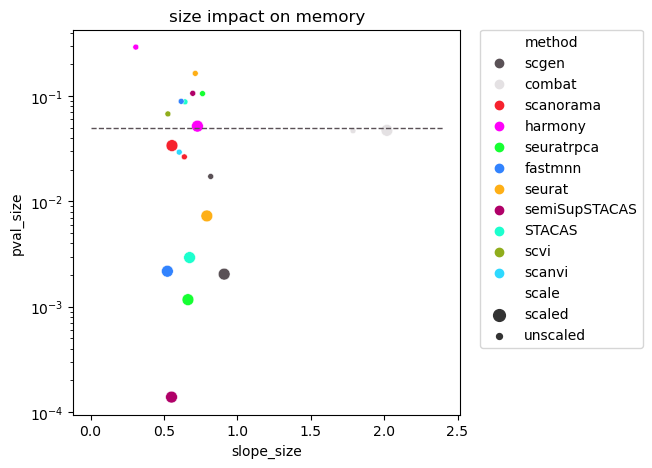

In [94]:
rcParams['figure.figsize'] = (5,5) 

ax = sb.scatterplot(x="slope_size", y="pval_size", hue='method', size='scale',
                            hue_order=hue_order,
                        #col='features', row='scale',
                        #order = meta['scenario'][np.argsort(meta['size'])].values,
                        data=fit_params_memory)
ax.set(yscale="log") 
        #plt.yticks([1e3, 1e4, 1e5, 1e6], ['1 GB', '10 GB', '100 GB', '1 TB'])
        #ax.set(xscale="log")
ax.set_title('size impact on memory')
plt.plot([0, 2.4], [0.05, 0.05], linewidth=1, linestyle='--')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

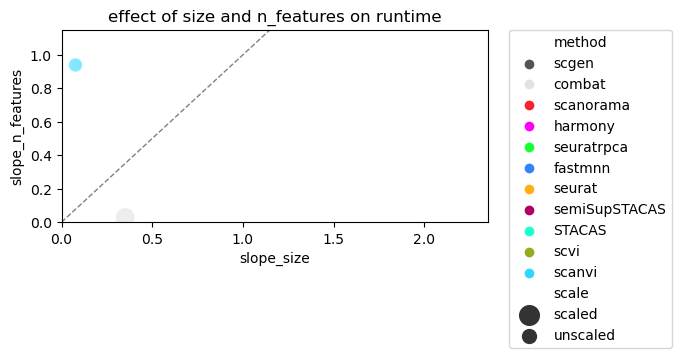

In [95]:
rcParams['figure.figsize'] = (5.5,2.5) 
fit_tmp = fit_params_time.loc[fit_params_time['pval_size']> 0]
ax = sb.scatterplot(x="slope_size", y="slope_n_features", hue='method', size='scale',sizes=(100, 200),
                    alpha=0.6,
                            hue_order=hue_order,
                        #col='features', row='scale',
                        #order = meta['scenario'][np.argsort(meta['size'])].values,
                        data=fit_tmp)
#ax.set(yscale="log") 
        #plt.yticks([1e3, 1e4, 1e5, 1e6], ['1 GB', '10 GB', '100 GB', '1 TB'])
        #ax.set(xscale="log")
ax.set_title('effect of size and n_features on runtime')
ax.set_ylim([0,1.15])
ax.set_xlim([0,2.35])
plt.plot([0, 1.2], [0, 1.2], linewidth=1, linestyle='--', color='grey')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#plt.savefig('./../figures/runtime_model_all_revision.pdf', bbox_inches='tight')
plt.show()

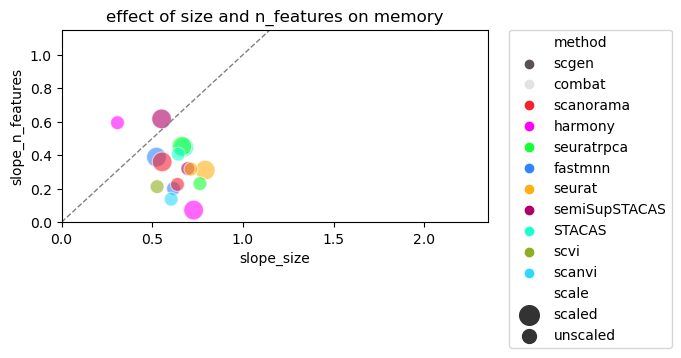

In [96]:
rcParams['figure.figsize'] = (5.5,2.5) 
fit_tmp = fit_params_memory.loc[fit_params_memory['pval_size']> 0]
ax = sb.scatterplot(x="slope_size", y="slope_n_features", hue='method',size='scale', 
                    sizes=(100, 200), alpha=0.6,
                            hue_order=hue_order,
                        #col='features', row='scale',
                        #order = meta['scenario'][np.argsort(meta['size'])].values,
                        data=fit_tmp)
#ax.set(yscale="log") 
        #plt.yticks([1e3, 1e4, 1e5, 1e6], ['1 GB', '10 GB', '100 GB', '1 TB'])
        #ax.set(xscale="log")
ax.set_title('effect of size and n_features on memory')
ax.set_ylim([0,1.15])
ax.set_xlim([0,2.35])
plt.plot([0, 1.2], [0, 1.2], linewidth=1, linestyle='--', color='grey')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#plt.savefig('./../figures/memory_model_all_revision.pdf', bbox_inches='tight')
plt.show()

Plot without the scaled data.

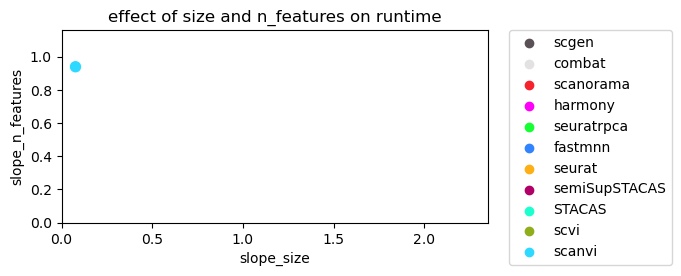

In [97]:
rcParams['figure.figsize'] = (5.5,2.5) 
fit_tmp = fit_params_time.loc[np.logical_and(fit_params_time['pval_size']> 0, fit_params_time['scale']=='unscaled')]
ax = sb.scatterplot(x="slope_size", y="slope_n_features", hue='method', s=80,
                   
                            hue_order=hue_order,
                        #col='features', row='scale',
                        #order = meta['scenario'][np.argsort(meta['size'])].values,
                        data=fit_tmp)
#ax.set(yscale="log") 
        #plt.yticks([1e3, 1e4, 1e5, 1e6], ['1 GB', '10 GB', '100 GB', '1 TB'])
        #ax.set(xscale="log")
ax.set_title('effect of size and n_features on runtime')
ax.set_ylim([0,1.16])
ax.set_xlim([0,2.35])
#plt.plot([0, 1.2], [0, 1.2], linewidth=1, linestyle='--', color='grey')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#plt.savefig('./../figures/runtime_model_unscaled_revision.pdf', bbox_inches='tight')
plt.show()

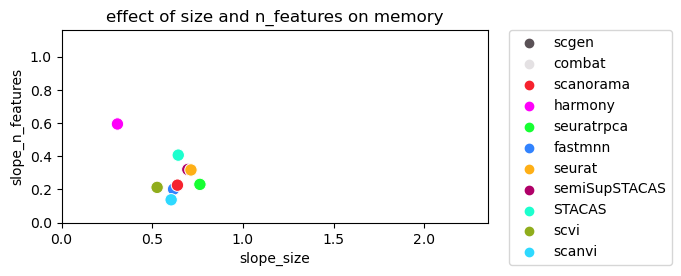

In [98]:
rcParams['figure.figsize'] = (5.5,2.5) 
fit_tmp = fit_params_memory.loc[np.logical_and(fit_params_memory['pval_size']> 0, fit_params_memory['scale']=='unscaled')]
ax = sb.scatterplot(x="slope_size", y="slope_n_features", hue='method', s=80,
                   
                            hue_order=hue_order,
                        #col='features', row='scale',
                        #order = meta['scenario'][np.argsort(meta['size'])].values,
                        data=fit_tmp)
#ax.set(yscale="log") 
        #plt.yticks([1e3, 1e4, 1e5, 1e6], ['1 GB', '10 GB', '100 GB', '1 TB'])
        #ax.set(xscale="log")
ax.set_title('effect of size and n_features on memory')
ax.set_ylim([0,1.16])
ax.set_xlim([0,2.35])
#plt.plot([0, 1.2], [0, 1.2], linewidth=1, linestyle='--', color='grey')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#plt.savefig('./../figures/memory_model_unscaled_revision.pdf', bbox_inches='tight')
plt.show()

In [101]:
runs_meta.to_csv('benchmark_meta.csv')